In [1]:
import numpy as np
import seaborn as sns

import ginsim
import biolqm
import maboss
from itertools import combinations # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import pandas as pd # for the visualization of lists of states
import pydot

import os

from tools import load_trajs, draw_graph_from_pandas, compute_circuits, compute_stg_counts

In [58]:
def to_bits(state, nodes):
    if state == "<nil>":
        return tuple([0]*len(nodes))
    bits = []
    state_list = state.split(" -- ")
    for node in nodes:
        bits.append(1 if node in state_list else 0)
    return tuple(bits)
def to_istates(table, nodes):
    istates = {}
    for index, value in table.iloc[-1, :].items():
        istates.update({to_bits(index, nodes): value})
    return istates

def change_input(istates, name_value):
    new_istates = {}
    for bits, proba in istates.items():
        new_bits = list(bits)
        for name in name_value:
            new_bits[nodes.index(name)] = name_value[name]
        new_tuples = tuple(new_bits)
        if new_tuples not in new_istates.keys():
            new_istates[new_tuples] = proba
        else:
            new_istates[new_tuples] += proba   
    return new_istates

In [2]:
path = "../config/differentiation/boolean_network/"

In [23]:
bnd_file = path + "tcell_corral.bnd"
cfg_file = path + "tcell_corral.cfg"

tcell_sim = maboss.load(bnd_file, cfg_file)

In [6]:
biolqm_model = maboss.to_biolqm(tcell_sim)

lrg = biolqm.to_ginsim(biolqm_model)

ginsim.show(lrg)

In [7]:
bnd_file = path + "dendritic_cells.bnd"
cfg_file = path + "dendritic_cells.cfg"

dendritic_cell_sim = maboss.load(bnd_file, cfg_file)

In [8]:
biolqm_model = maboss.to_biolqm(dendritic_cell_sim)

lrg = biolqm.to_ginsim(biolqm_model)

ginsim.show(lrg)

In [60]:
input_tcell = ["IL1_In", "MHCII_b1", "MHCII_b2", "IL12_In", "IL6_In", "CD4", "CD80", "IL23_In", "PIP2"]

In [43]:
output_physiboss = ["IL12RB1" , "IL12RB2" , "GP130" , "STAT5B_b1" , "IL1RAP" , "IL1R1" , "STAT5B_b2" , "CXCR4", "IL2RB", "CGC"]
output_maboss = ["Treg", "Th17", "Th1"]
nodes_phenotype = ["FOXP3", "FOXP3_2", "RORGt", "Tbet", "CD4"]

In [44]:
input_tcell_dict = {element: 0 for element in input_tcell}

In [45]:
#Wild type Tcell

#This is a simulation where all the nodes are 0. The starting point of the PysiBoSS simulation.
sim = tcell_sim.copy()
sim.network.set_output(output_physiboss)
sim.update_parameters(sample_count=1000,max_time=100, time_tick=0.5)
maboss.set_nodes_istate(sim, sim.network.keys(), [1, 0])

In [46]:
sim.get_initial_state();

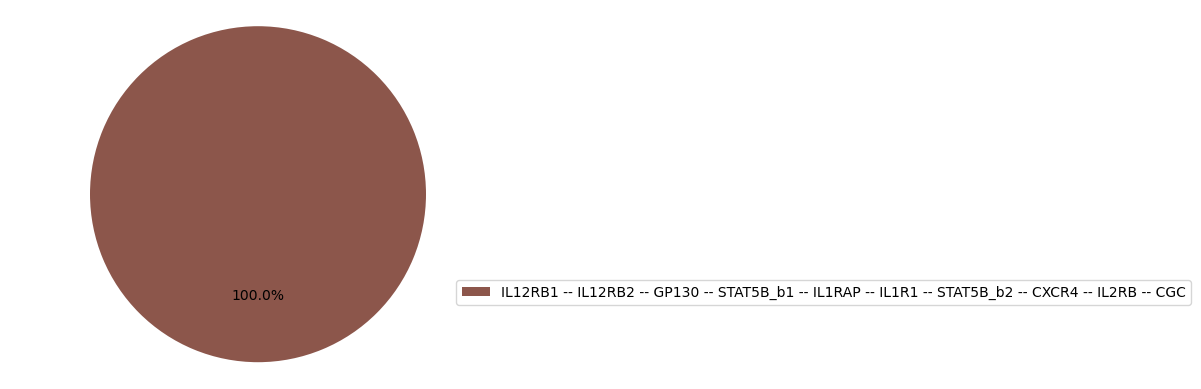

In [47]:
model = sim.run()

model.plot_piechart()

### The result of the previous simulation shows that none of the phenotype nodes (Treg, Th17, Th1) are active. The dendritic cells while deliver their input to the tcell in this stable state.

In [63]:
nodes = list(sim.network.keys())
input_tcell_dict = {element: 1 for element in input_tcell}

### Now we assign this state as initial state for a new simulation and on top of that we are going to activate the input nodes that the dendritic cells will activate in the PhysiBoSS simulation 

In [64]:
new_istates = change_input(to_istates(model.get_states_probtraj(), nodes), input_tcell_dict)

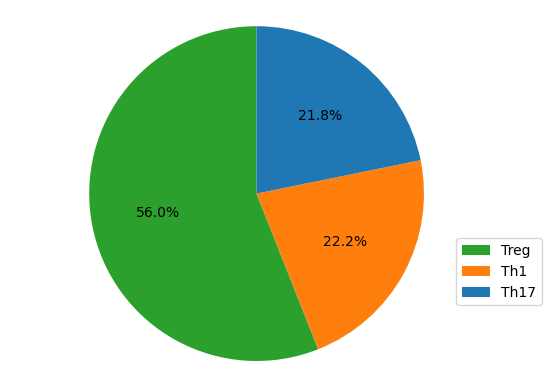

In [65]:
sim_next = sim.copy()
sim_next.network.set_output(output_maboss)
sim_next.update_parameters(sample_count=1000,max_time=100, time_tick=0.5)
sim_next.network.set_istate(nodes, new_istates)


model_activated = sim_next.run()

model_activated.plot_piechart()

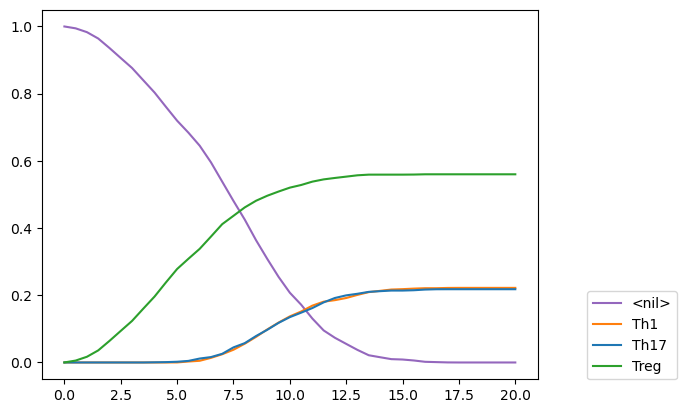

In [67]:
model_activated.plot_trajectory(until=20)

In [70]:
model_activated.get_states_probtraj().iloc[-1,:]

<nil>    0.000
Th1      0.222
Th17     0.218
Treg     0.560
Name: 99.0, dtype: float64

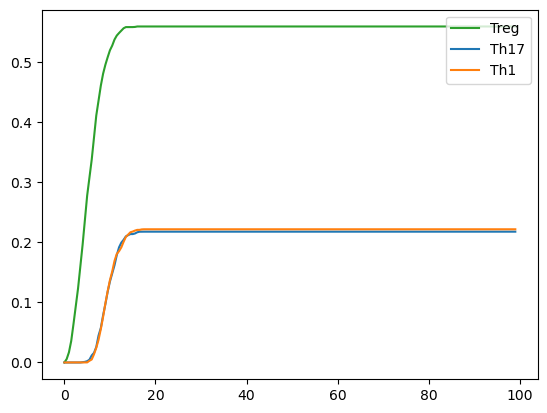

In [71]:
model_activated.plot_node_trajectory()

## The input delivered by the dendritic cells, will allow the differentiation of the naive tcell into Treg, Th17 and Th1

# Analysis of the Mutants

### Now we are going to test a series of mutations in the model. To perform this kind of analysis, we are not going to test the mutations on the wild type state, but on the stable state prior to contact with the dendritic cells. Moreover, we are going to test the input delivered by the dendritic cells to those mutations results that did not trigger any differentiation. The objective of this analysis is to search for undifferentiated stable state of the network that are more vulnerable or more resistant to the dendritic cell contact.

In [72]:
def simulate_single_mutants(model, list_nodes, sign="BOTH"):
    
    list_single_mutants = []
    if (sign == "BOTH" or sign == "ON"):
        list_single_mutants += [(node, "ON") for node in list_nodes]
    if (sign == "BOTH" or sign == "OFF"):
        list_single_mutants += [(node, "OFF") for node in list_nodes]
    
    res = {}
    for single_mutant in list_single_mutants:
        t_model = model.copy()
        t_model.mutate(*single_mutant)
        res.update({single_mutant: t_model.run()})
        
    return res

In [73]:
def simulate_double_mutants(model, list_nodes, sign="BOTH"):
    
    list_single_mutants = []
    if (sign == "BOTH" or sign == "ON"):
        list_single_mutants += [(node, "ON") for node in list_nodes]
    if (sign == "BOTH" or sign == "OFF"):
        list_single_mutants += [(node, "OFF") for node in list_nodes]
    
    list_double_mutants = [(a, b) for idx, a in enumerate(list_single_mutants) for b in list_single_mutants[idx + 1:] if a[0] != b[0]]

    res = {}
    for double_mutant in list_double_mutants:
        t_model = model.copy()
        t_model.mutate(*(double_mutant[0]))
        t_model.mutate(*(double_mutant[1]))
        res.update({double_mutant: t_model.run()})
        
    return res

In [74]:
def filter_sensititivy(results, state=None, node=None, minimum=None, maximum=None):
    ret_res = {}
    for (mutant, res) in results.items():
        
        if state is not None:
            t_res = res.get_last_states_probtraj()
            if state in t_res.columns:
                if minimum is not None and maximum is not None:
                    if t_res[state].values[0] > minimum and t_res[state].values[0] < maximum:
                        ret_res.update({mutant: res})
                elif minimum is not None and t_res[state].values[0] > minimum:
                    ret_res.update({mutant: res})
                elif maximum is not None and t_res[state].values[0] < maximum:
                    ret_res.update({mutant: res})
            elif maximum is not None and minimum is None:
                ret_res.update({mutant:res})

        elif node is not None:
            
            t_res = res.get_last_nodes_probtraj()

            if node in t_res.columns:
                if minimum is not None and maximum is not None:
                    if t_res[node].values[0] > minimum and t_res[node].values[0] < maximum:
                        ret_res.update({mutant: res})
                elif minimum is not None and t_res[node].values[0] > minimum:
                    ret_res.update({mutant: res})
                elif maximum is not None and t_res[node].values[0] < maximum:
                    ret_res.update({mutant: res})
            elif maximum is not None and minimum is None:
                ret_res.update({mutant: res})

    return ret_res


In [92]:
def compute_input_on_mutations(model, res_mutations, nodes, inputs):
    new_results = {}
    for mutation_target in res_mutations:
        mutation_result = res_mutations[mutation_target]
        new_istates = change_input(to_istates(mutation_result.get_states_probtraj(), nodes), inputs)
        s_model = model.copy()
        s_model.network.set_istate(nodes, new_istates)

        new_results.update({mutation_target: s_model.run()})
    return new_results
        

In [75]:
sim_test_single_mut = sim.copy()
sim_test_single_mut.network.set_output(output_maboss)

In [198]:
nodes_test = ['PI3K_b1', 'PI3K_b2', 'IL6_Aut', 'IL12R', 'IL6R', 'STAT1', 'Tbet', 'AP1', 'NFAT1', 'NFKB', 'Blimp1_b1', 'Blimp1_b2', 'RUNX1_b1', 'RUNX1_b2', 'STAT4', 'RUNX3', 'EOMES', 'IFNg', 'IL12RB1', 'IL12RB2', 'IL1RAP', 'IL1R1', 'IL1R', 'IL23R', 'STAT3', 'cMAF', 'IL21', 'RORGt', 'IRF4', 'AHR', 'NFAT2A_b1', 'NFAT2A_b2', 'STAT5B_b1', 'STAT5B_b2', 'SMAD2', 'RORA', 'STAT5A_b1', 'STAT5A_b2', 'IL17A', 'IL17F', 'LCK', 'TCR_b1', 'TCR_b2', 'CD28', 'ZAP70', 'LAT', 'VAV', 'RAS', 'SOS', 'PLCG', 'RAC', 'FOXP3', 'PTEN', 'PIP3', 'IP3', 'DAG', 'PKCO', 'ITK_b1', 'ERK1_2', 'cFOS', 'cJUN', 'MEKK1', 'TRAF6', 'TAK1', 'IKK', 'Myd88', 'IRAK1_4', 'NFAT2', 'NFAT4', 'IL2RA', 'IL2RB', 'CGC', 'IL2', 'IL2R_b1', 'IL2R_b2', 'SATB1', 'TGFBR', 'GP130', 'MINA', 'FOXP3_2', 'TGFB_In', 'CXCR4', 'ITK_b2']
nodes_test;

In [199]:
res_single = simulate_single_mutants(sim_test_single_mut, nodes_test)

### In the following cell, we filter the results because we want to test the input delivered by the mDCs on an undifferentiated population of T0.

In [200]:
filtered_res = filter_sensititivy(res_single, node="Treg", maximum=0)
filtered_res = filter_sensititivy(filtered_res, node="Th1", maximum=0)
filtered_res = filter_sensititivy(filtered_res, node="Th17", maximum=0)
filtered_res

{('PI3K_b1', 'ON'): <maboss.result.Result at 0x7f8ec2c27dc0>,
 ('PI3K_b2', 'ON'): <maboss.result.Result at 0x7f8ec2e11490>,
 ('IL6_Aut', 'ON'): <maboss.result.Result at 0x7f8ec2c5b0d0>,
 ('IL12R', 'ON'): <maboss.result.Result at 0x7f8ec2cb0df0>,
 ('IL6R', 'ON'): <maboss.result.Result at 0x7f8ec3240a30>,
 ('STAT1', 'ON'): <maboss.result.Result at 0x7f8ec2c40e80>,
 ('AP1', 'ON'): <maboss.result.Result at 0x7f8ec2c27580>,
 ('NFAT1', 'ON'): <maboss.result.Result at 0x7f8ec2f53e20>,
 ('NFKB', 'ON'): <maboss.result.Result at 0x7f8ec2dbe3d0>,
 ('Blimp1_b1', 'ON'): <maboss.result.Result at 0x7f8ec2f40c70>,
 ('Blimp1_b2', 'ON'): <maboss.result.Result at 0x7f8ec2dc9d00>,
 ('RUNX1_b1', 'ON'): <maboss.result.Result at 0x7f8ec2c40d90>,
 ('RUNX1_b2', 'ON'): <maboss.result.Result at 0x7f8ec2e2d760>,
 ('STAT4', 'ON'): <maboss.result.Result at 0x7f8ec2c17a90>,
 ('RUNX3', 'ON'): <maboss.result.Result at 0x7f8ec2dc9b50>,
 ('EOMES', 'ON'): <maboss.result.Result at 0x7f8ec2c403a0>,
 ('IFNg', 'ON'): <maboss

In [201]:
stable_state = sim.copy()
nodes = list(stable_state.network.keys())
inputs = input_tcell_dict = {element: 1 for element in input_tcell}
stable_state.network.set_output(output_maboss)

In [118]:
updated_mutations = compute_input_on_mutations(stable_state, filtered_res, nodes, inputs)

In [184]:
filtered_mutations_Treg = filter_sensititivy(updated_mutations, node="Treg", maximum=0.468)
filtered_mutations_Treg

{('IRF4', 'ON'): <maboss.result.Result at 0x7f916845f0d0>,
 ('TCR_b2', 'OFF'): <maboss.result.Result at 0x7f91684684c0>}

('IRF4', 'ON')
('TCR_b2', 'OFF')


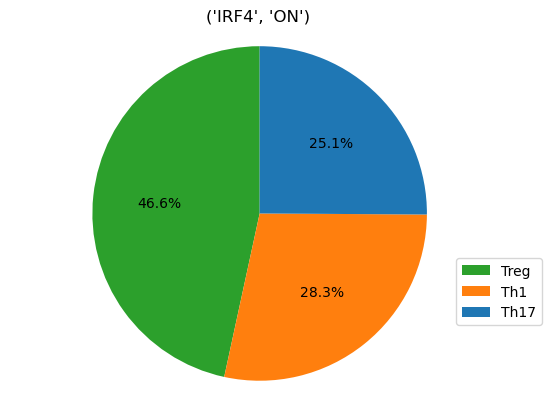

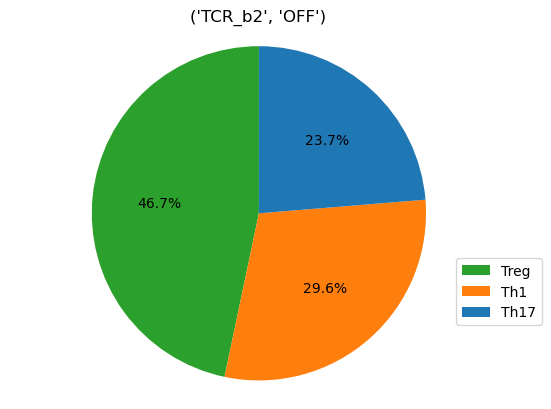

In [185]:
for mutant, res in filtered_mutations_Treg.items():
    print(mutant)
    res.plot_piechart()
    plt.title(mutant)

In [195]:
filtered_mutations_Th1 = filter_sensititivy(updated_mutations, node="Th1", maximum=0.243)
filtered_mutations_Th1

{('PLCG', 'OFF'): <maboss.result.Result at 0x7f91684dbe80>}

('PLCG', 'OFF')


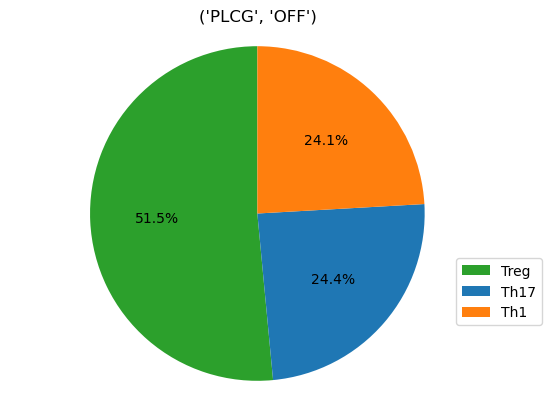

In [196]:
for mutant, res in filtered_mutations_Th1.items():
    print(mutant)
    res.plot_piechart()
    plt.title(mutant)

In [189]:
filtered_mutations_Th17 = filter_sensititivy(updated_mutations, node="Th17", maximum=0.196)
filtered_mutations_Th17

{('VAV', 'ON'): <maboss.result.Result at 0x7f9168539700>}

('VAV', 'ON')


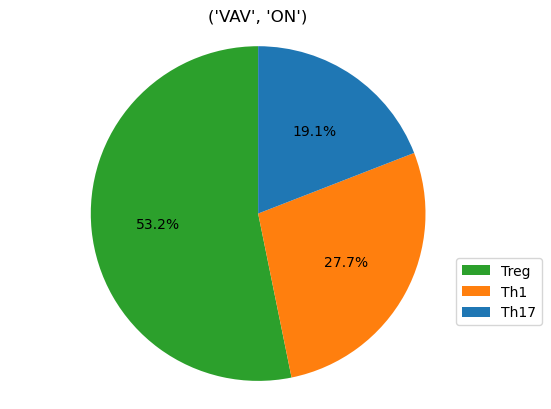

In [190]:
for mutant, res in filtered_mutations_Th17.items():
    print(mutant)
    res.plot_piechart()
    plt.title(mutant)

## As we can observe, no single mutation resulted in a drastic change of the original model behavior. However, the single mutations reported above, can slightly change the cell population of the three cell types. This may have an impact on a very large number of cells.

# Next we are going to test a series of double mutations, in the same way as we did before.

In [123]:
sim_test_double_mut = sim.copy()
sim_test_double_mut.network.set_output(output_maboss)

nodes_test = ['PI3K_b1', 'PI3K_b2', 'IL6_Aut', 'IL12R', 'IL6R', 'STAT1', 'AP1', 'NFAT1', 'NFKB', 'Blimp1_b1', 'Blimp1_b2', 'RUNX1_b1', 'RUNX1_b2', 'STAT4', 'RUNX3', 'EOMES', 'IFNg', 'IL12RB1', 'IL12RB2', 'IL1RAP', 'IL1R1', 'IL1R', 'IL23R', 'STAT3', 'cMAF', 'IL21', 'IRF4', 'AHR', 'NFAT2A_b1', 'NFAT2A_b2', 'STAT5B_b1', 'STAT5B_b2', 'SMAD2', 'RORA', 'STAT5A_b1', 'STAT5A_b2', 'IL17A', 'IL17F', 'LCK', 'TCR_b1', 'TCR_b2', 'CD28', 'ZAP70', 'LAT', 'VAV', 'RAS', 'SOS', 'PLCG', 'RAC', 'PTEN', 'PIP3', 'IP3', 'DAG', 'PKCO', 'ITK_b1', 'ERK1_2', 'cFOS', 'cJUN', 'MEKK1', 'TRAF6', 'TAK1', 'IKK', 'Myd88', 'IRAK1_4', 'NFAT2', 'NFAT4', 'IL2RA', 'IL2RB', 'CGC', 'IL2', 'IL2R_b1', 'IL2R_b2', 'SATB1', 'TGFBR', 'GP130', 'MINA', 'TGFB_In', 'CXCR4', 'ITK_b2']
nodes_test;

('PI3K_b1', 'ON')
('PI3K_b2', 'ON')
('IL6_Aut', 'ON')
('IL12R', 'ON')
('IL6R', 'ON')
('STAT1', 'ON')
('Tbet', 'ON')
('AP1', 'ON')
('NFAT1', 'ON')
('NFKB', 'ON')
('Blimp1_b1', 'ON')
('Blimp1_b2', 'ON')
('RUNX1_b1', 'ON')
('RUNX1_b2', 'ON')
('STAT4', 'ON')
('RUNX3', 'ON')
('EOMES', 'ON')
('IFNg', 'ON')
('IL12RB1', 'ON')
('IL12RB2', 'ON')
('IL1RAP', 'ON')
('IL1R1', 'ON')


/home/marco/anaconda3/envs/MaBoSS_env/lib/python3.9/site-packages/maboss/results/baseresult.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, axes = plt.subplots(1,1)


('IL1R', 'ON')
('IL23R', 'ON')
('STAT3', 'ON')
('cMAF', 'ON')
('IL21', 'ON')
('RORGt', 'ON')
('IRF4', 'ON')
('AHR', 'ON')
('NFAT2A_b1', 'ON')
('NFAT2A_b2', 'ON')
('STAT5B_b1', 'ON')
('STAT5B_b2', 'ON')
('SMAD2', 'ON')
('RORA', 'ON')
('STAT5A_b1', 'ON')
('STAT5A_b2', 'ON')
('IL17A', 'ON')
('IL17F', 'ON')
('LCK', 'ON')
('TCR_b1', 'ON')
('TCR_b2', 'ON')
('CD28', 'ON')
('ZAP70', 'ON')
('LAT', 'ON')
('VAV', 'ON')
('RAS', 'ON')
('SOS', 'ON')
('PLCG', 'ON')
('RAC', 'ON')
('FOXP3', 'ON')
('PTEN', 'ON')
('PIP3', 'ON')
('IP3', 'ON')
('DAG', 'ON')
('PKCO', 'ON')
('ITK_b1', 'ON')
('ERK1_2', 'ON')
('cFOS', 'ON')
('cJUN', 'ON')
('MEKK1', 'ON')
('TRAF6', 'ON')
('TAK1', 'ON')
('IKK', 'ON')
('Myd88', 'ON')
('IRAK1_4', 'ON')
('NFAT2', 'ON')
('NFAT4', 'ON')
('IL2RA', 'ON')
('IL2RB', 'ON')
('CGC', 'ON')
('IL2', 'ON')
('IL2R_b1', 'ON')
('IL2R_b2', 'ON')
('SATB1', 'ON')
('TGFBR', 'ON')
('GP130', 'ON')
('MINA', 'ON')
('FOXP3_2', 'ON')
('TGFB_In', 'ON')
('CXCR4', 'ON')
('ITK_b2', 'ON')
('PI3K_b1', 'OFF')
('PI

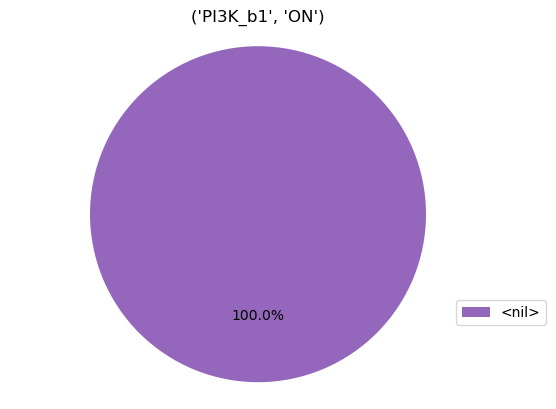

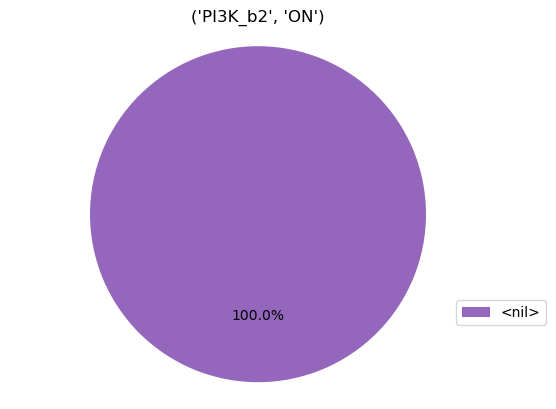

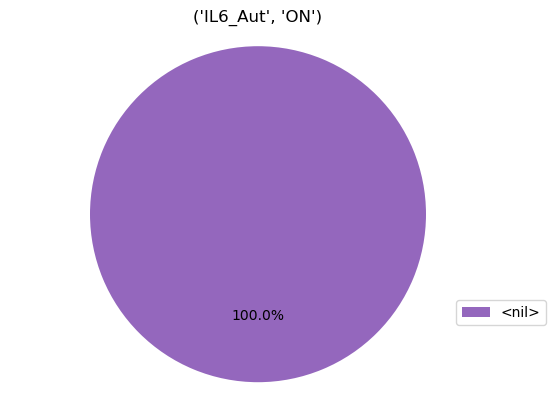

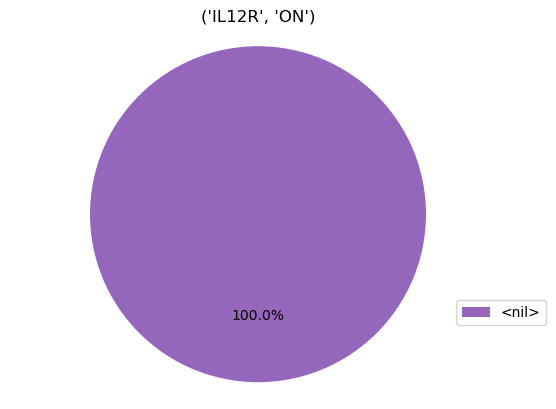

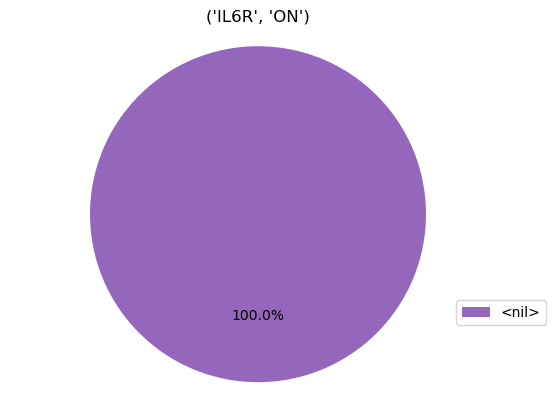

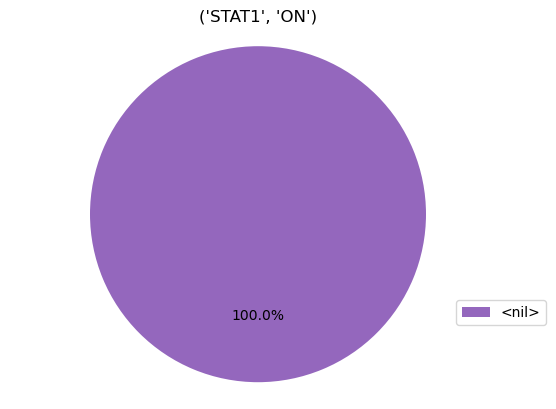

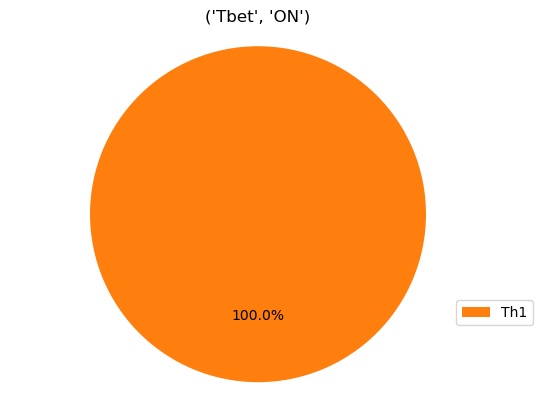

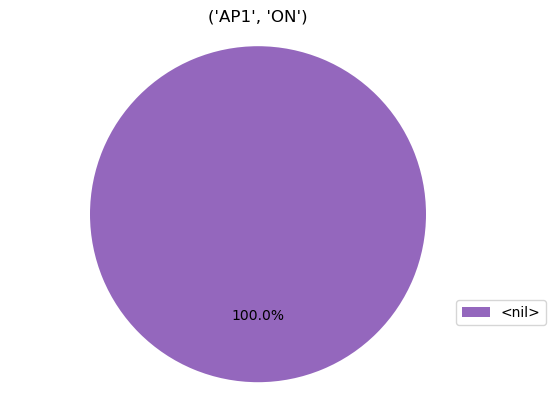

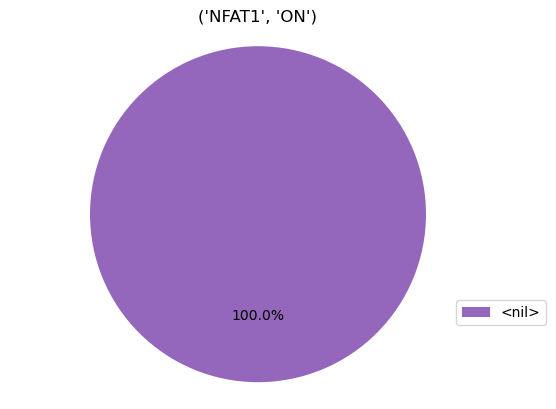

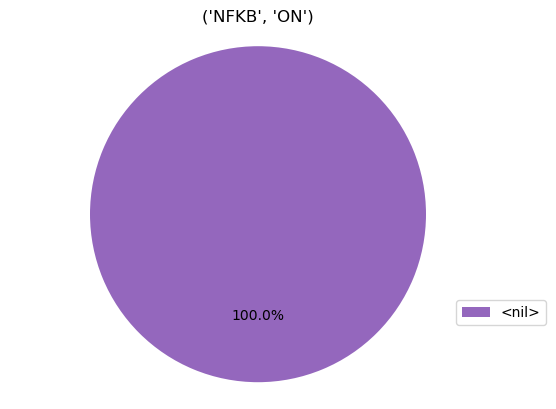

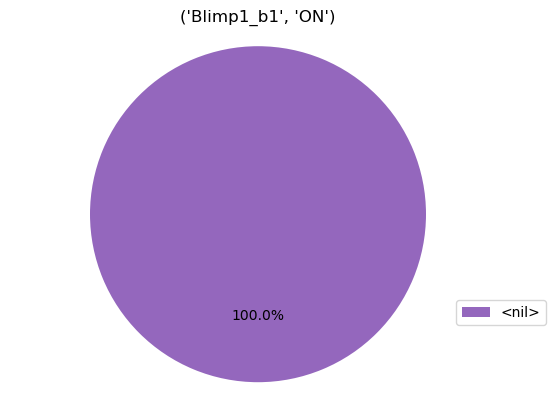

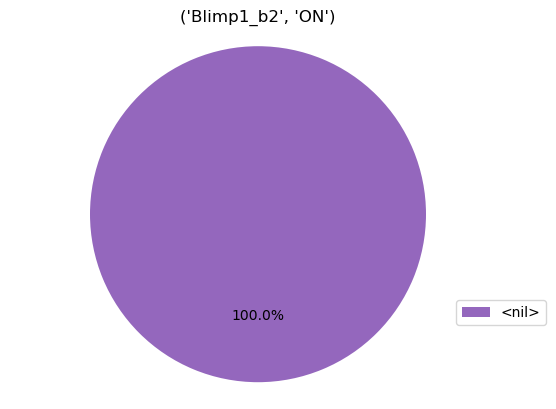

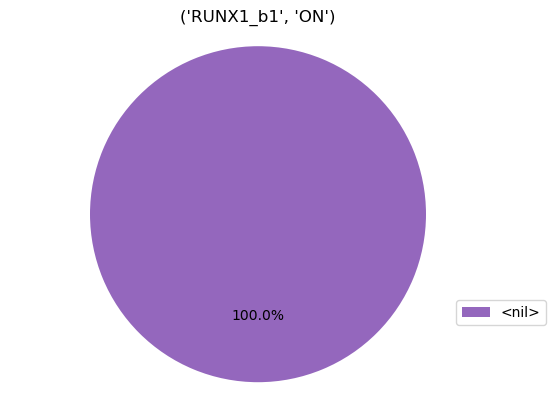

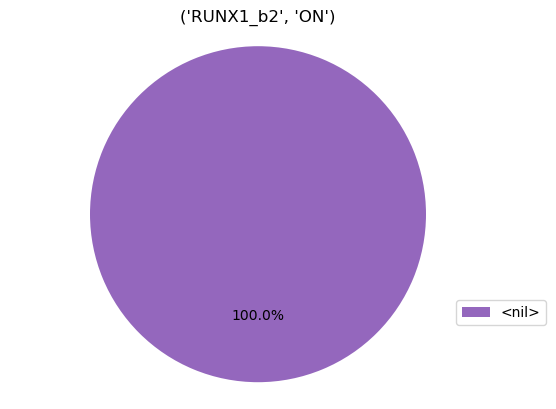

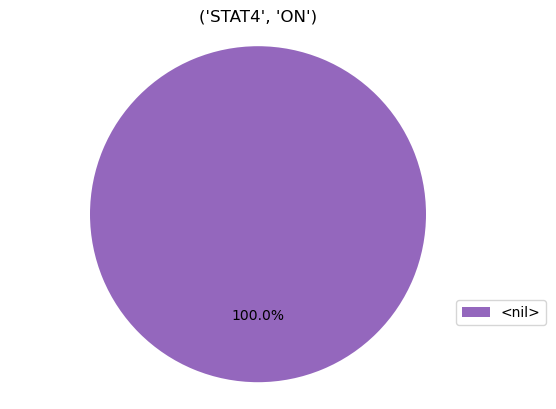

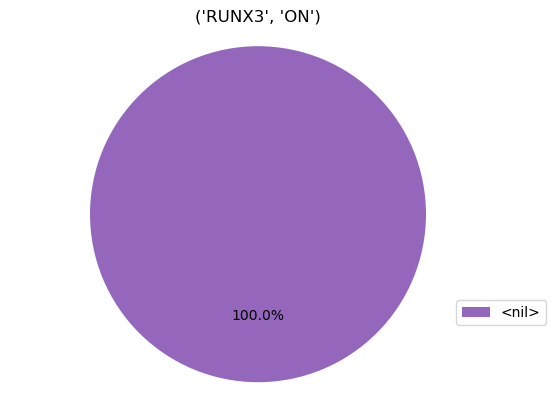

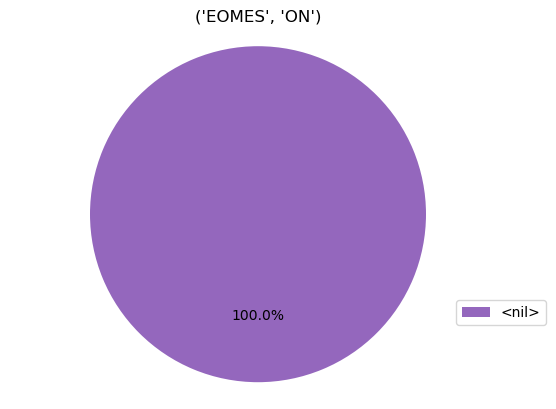

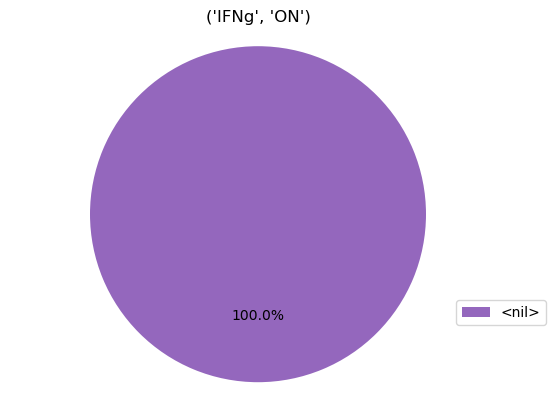

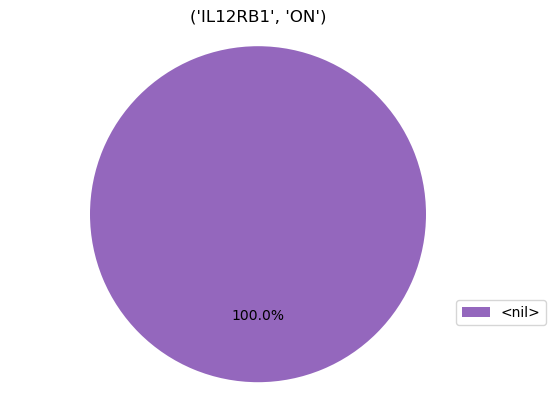

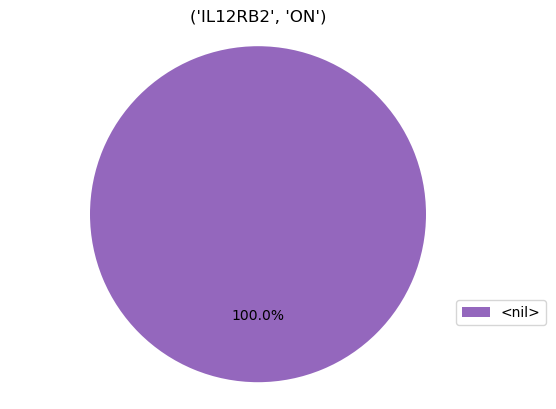

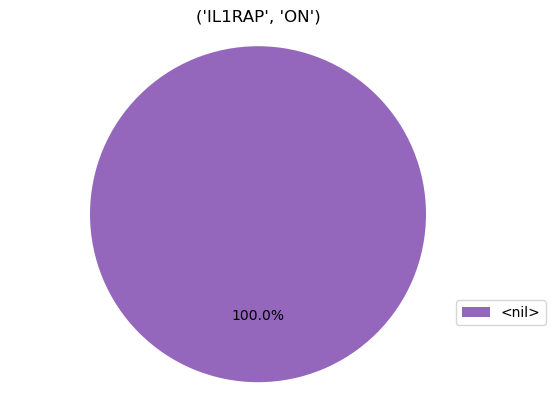

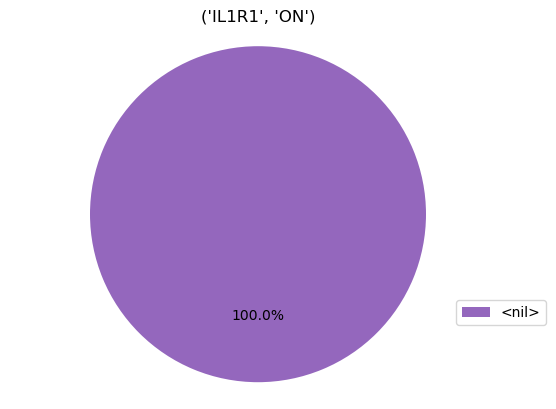

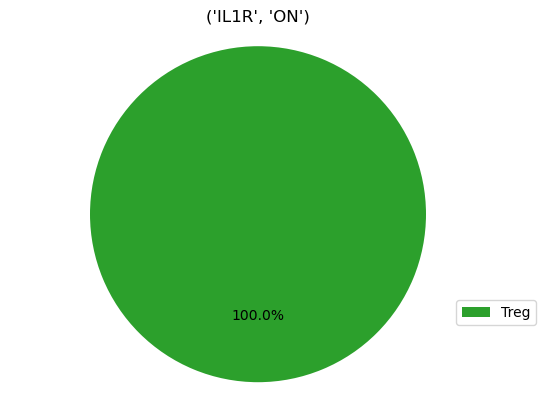

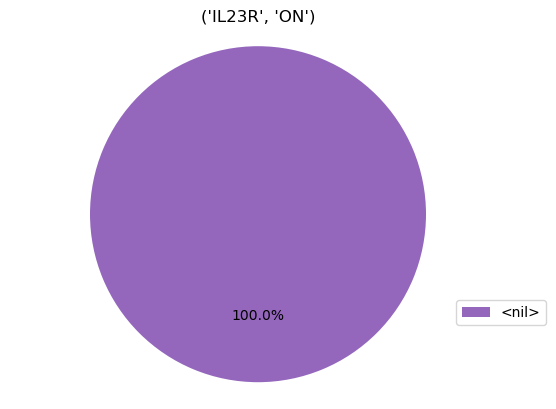

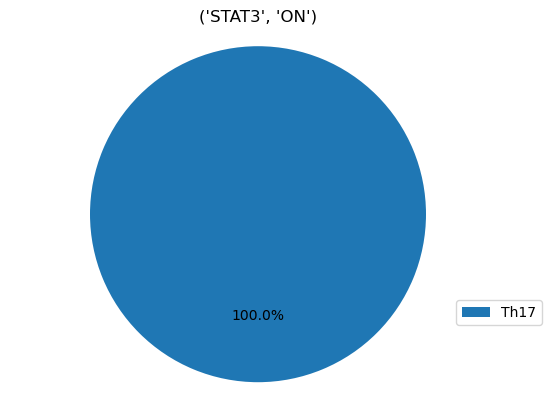

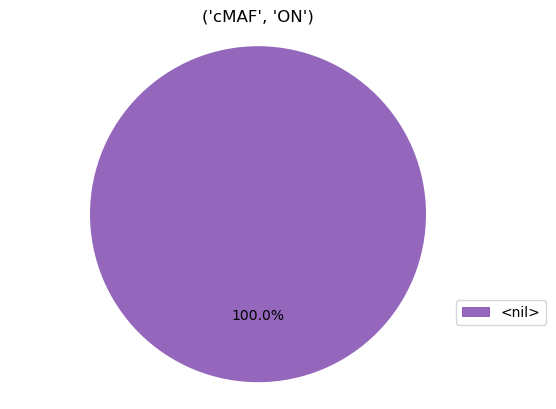

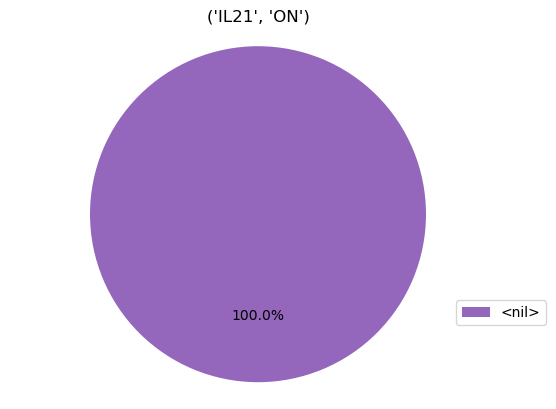

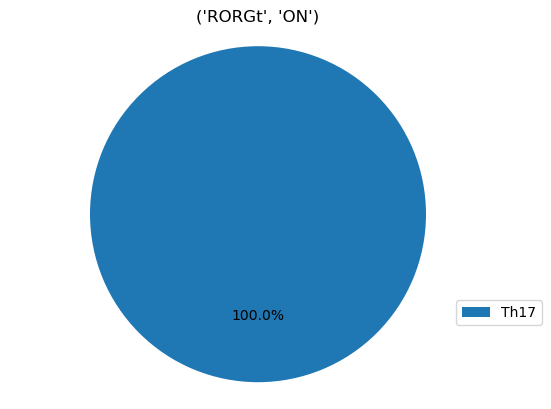

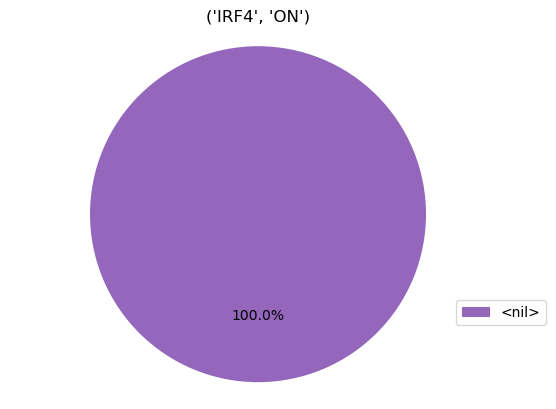

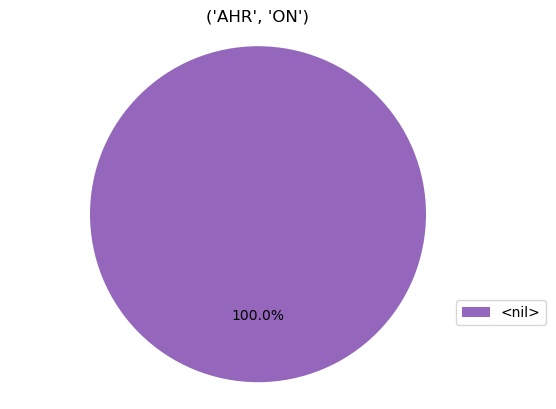

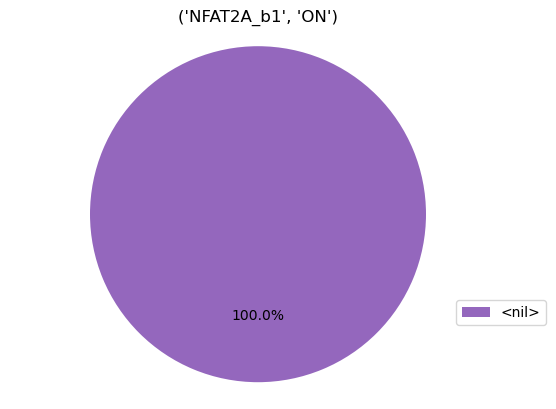

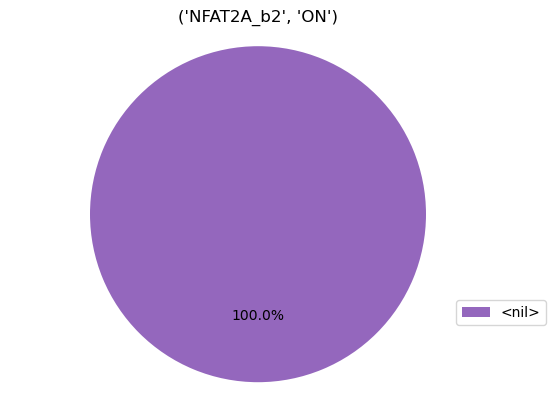

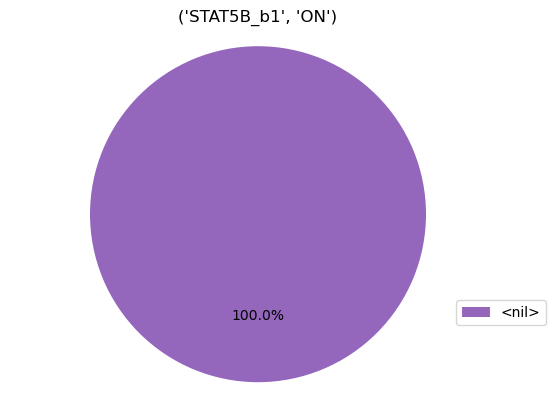

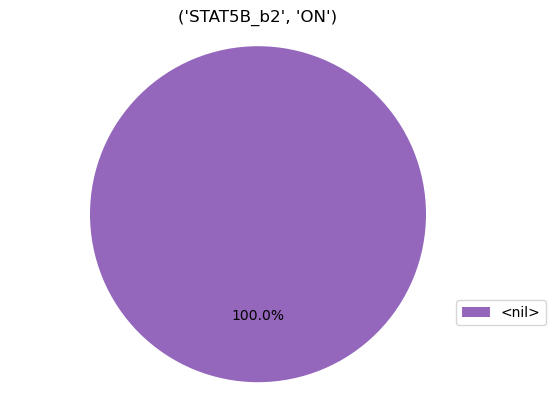

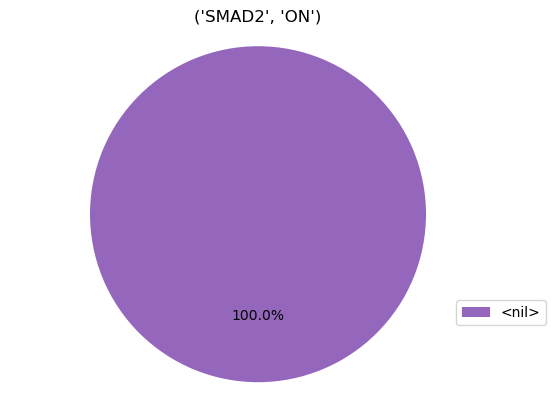

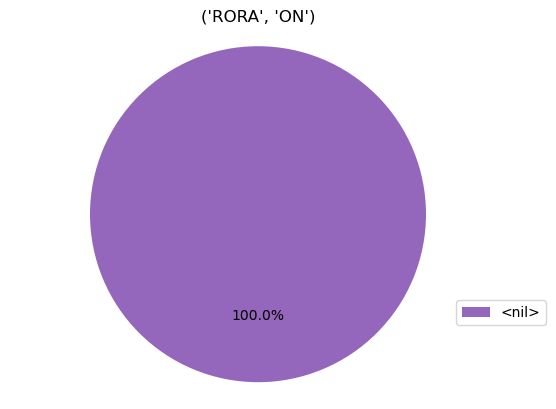

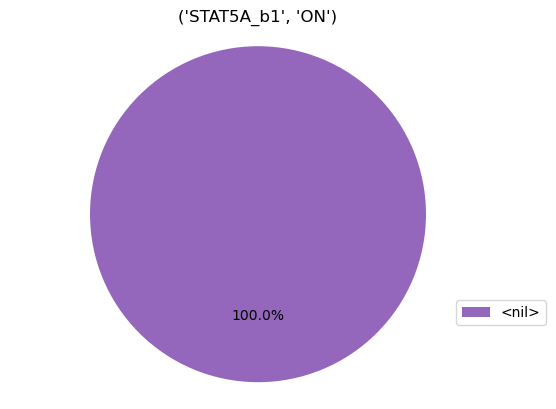

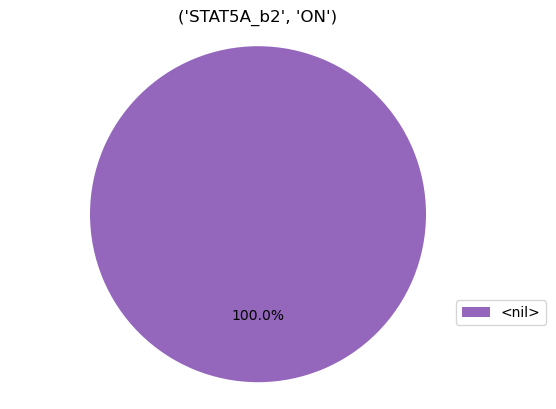

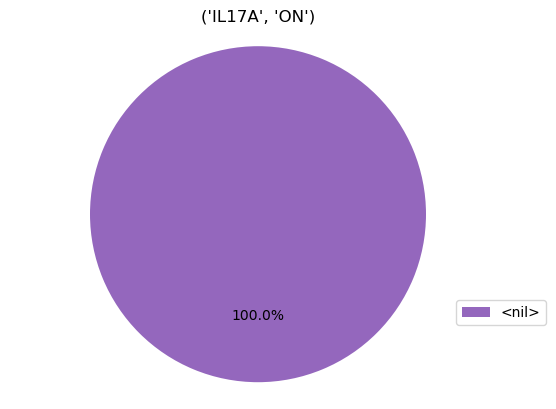

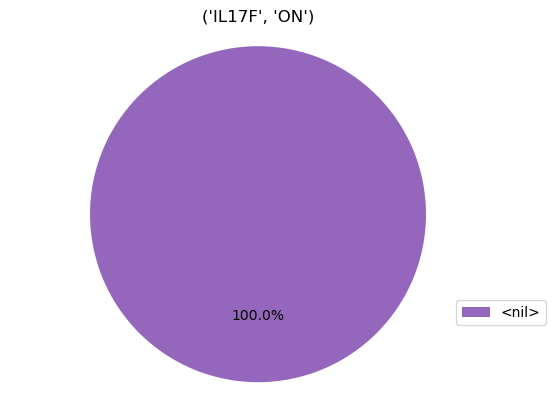

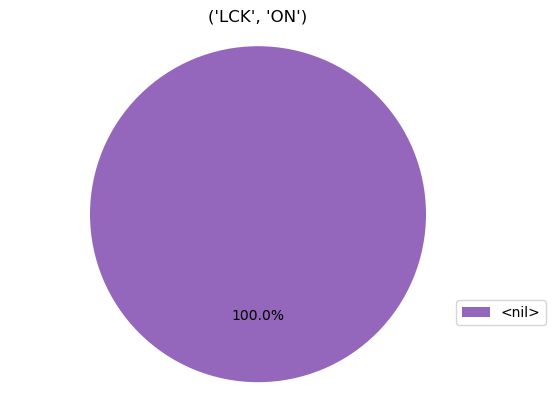

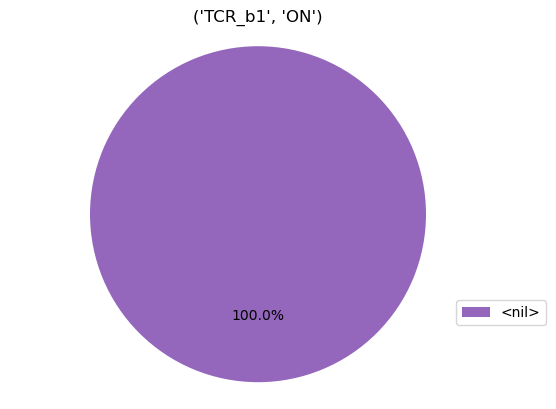

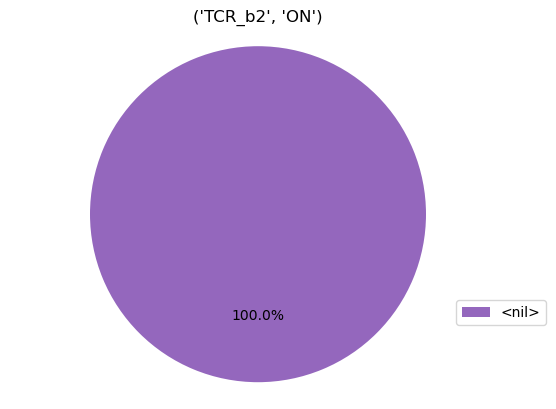

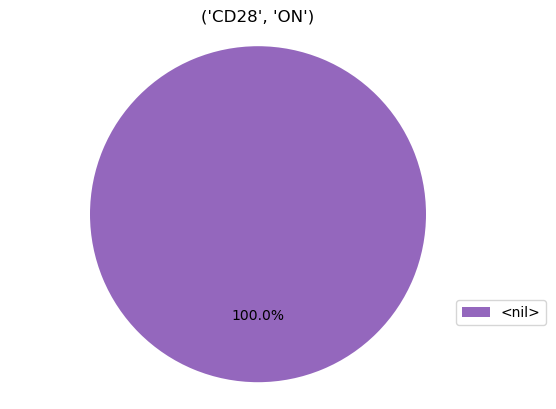

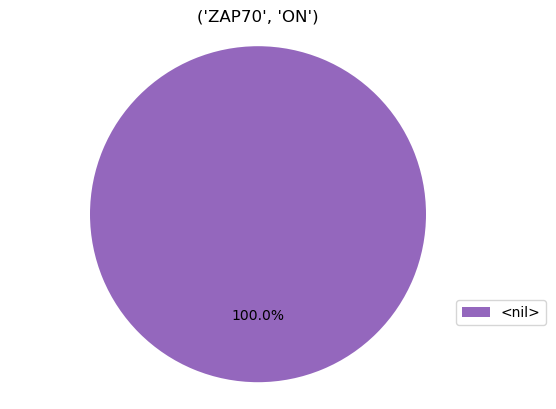

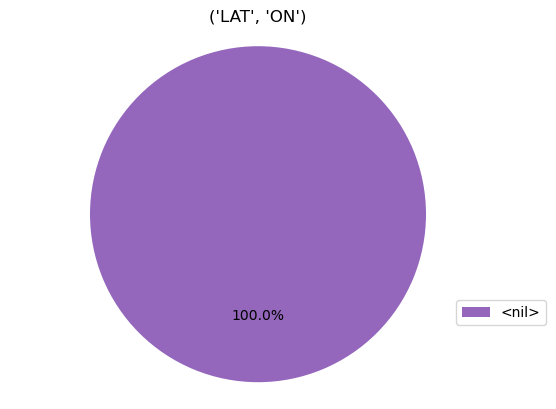

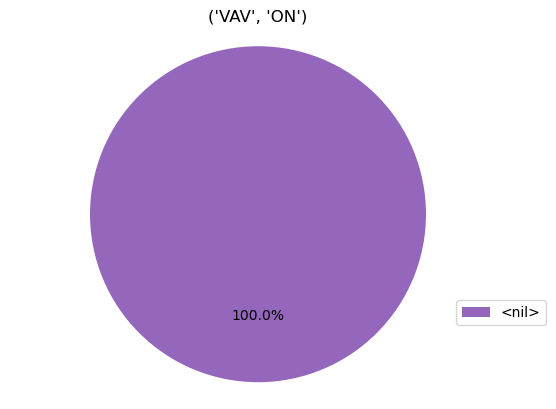

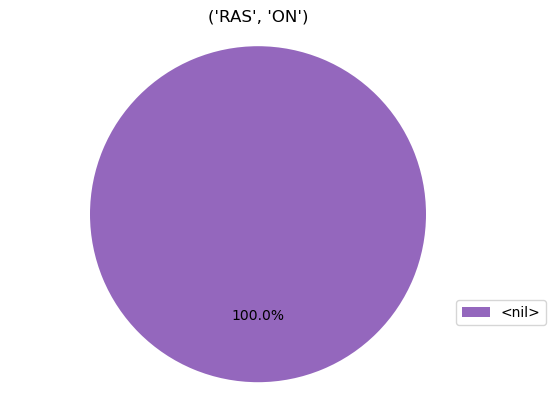

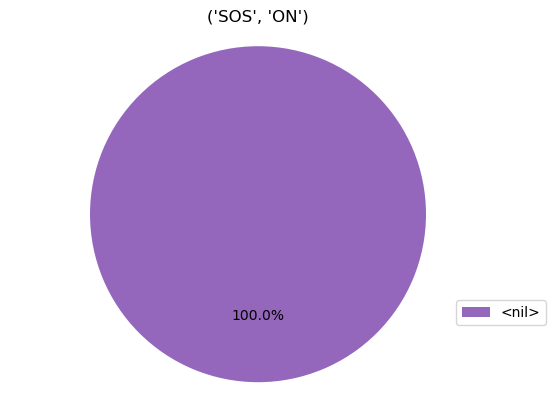

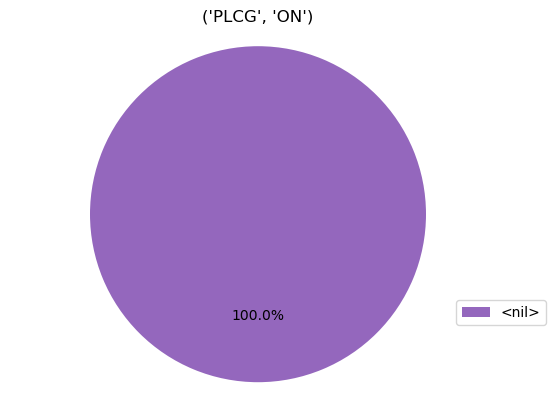

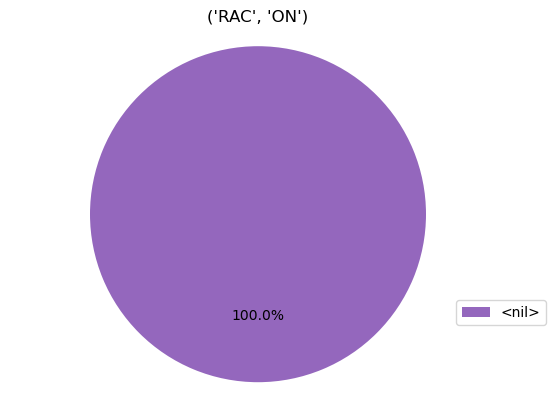

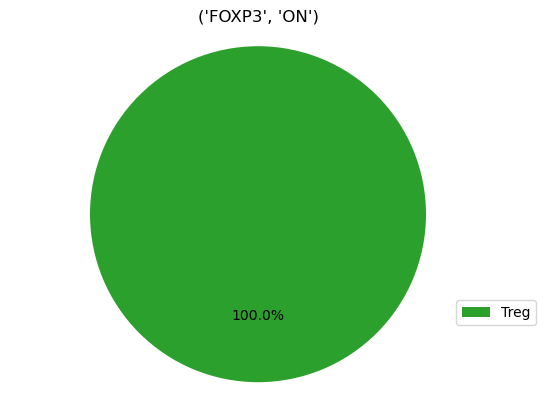

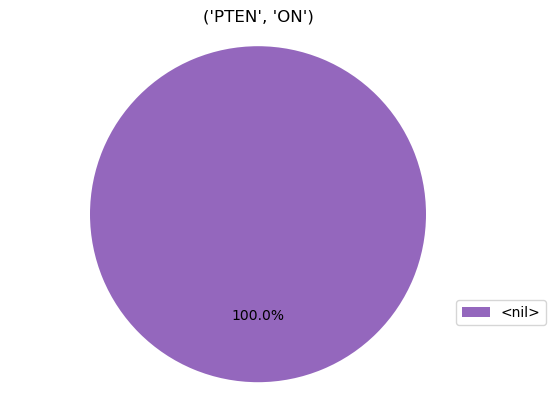

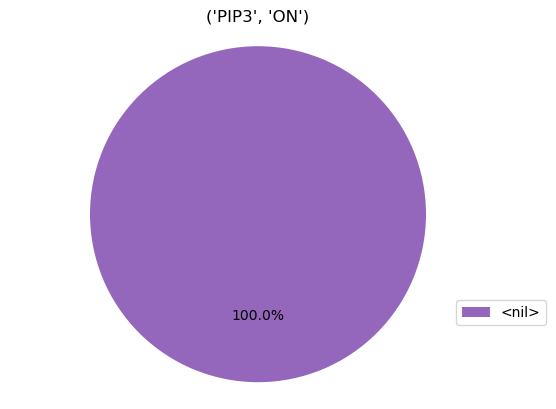

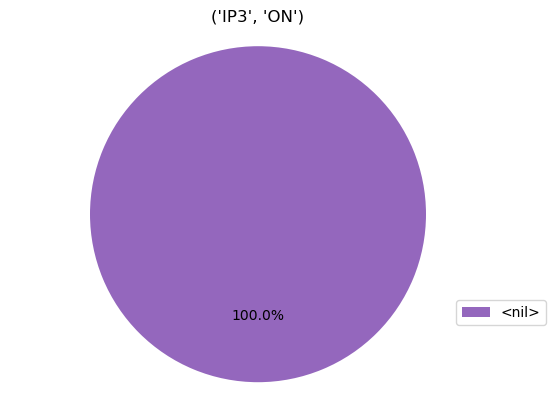

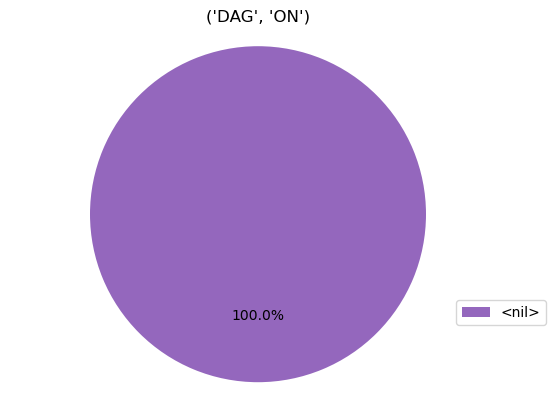

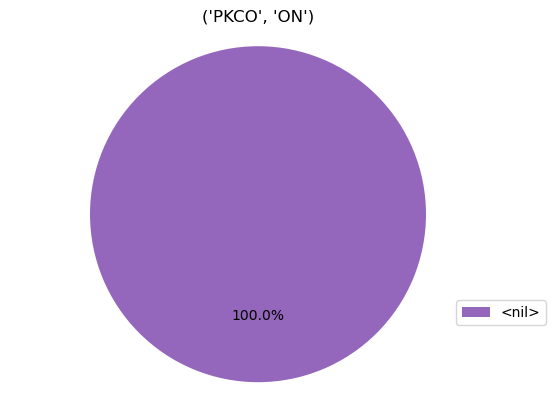

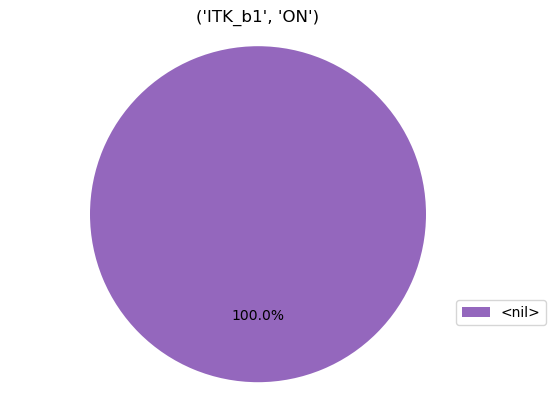

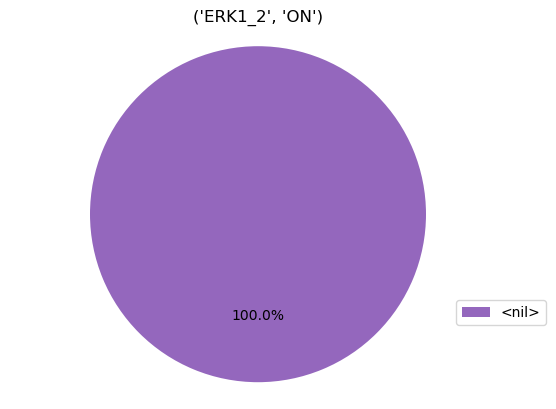

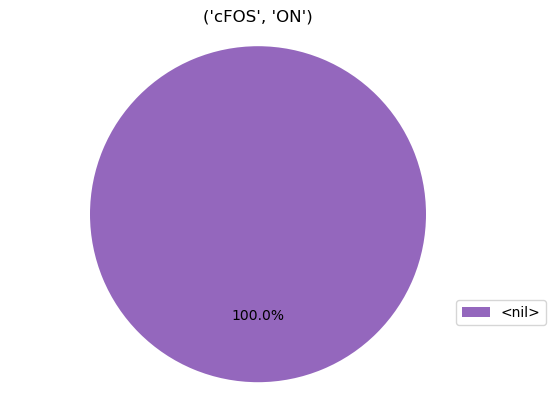

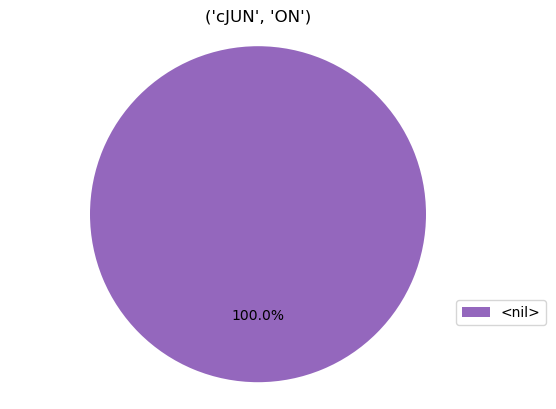

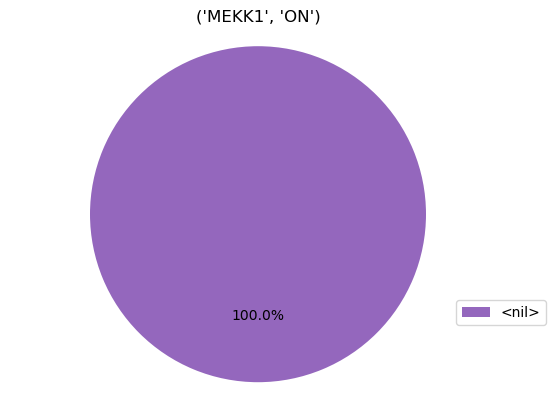

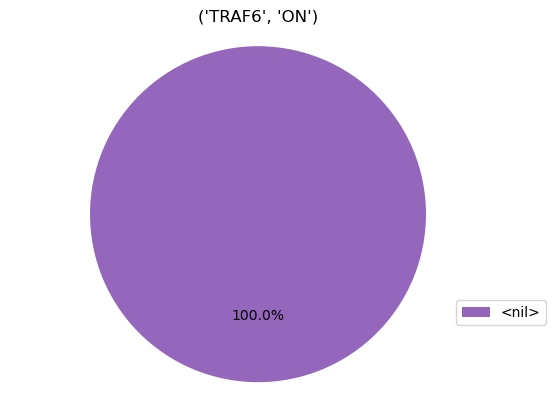

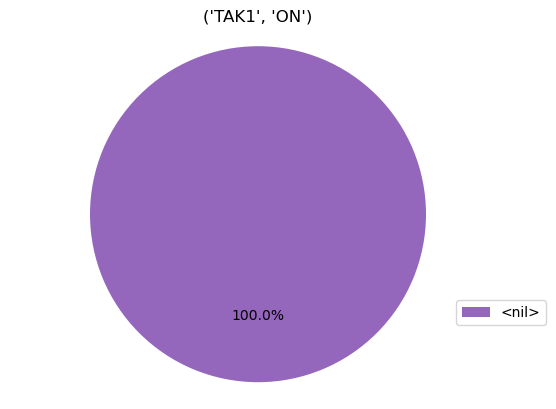

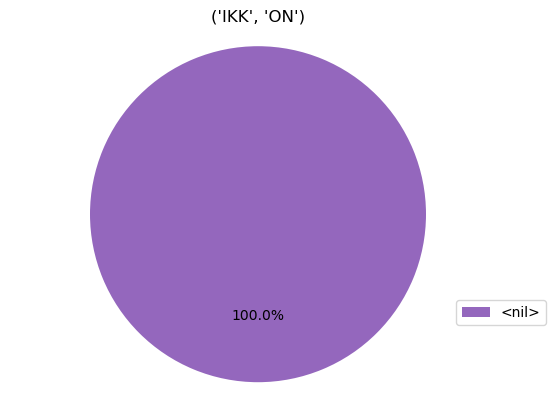

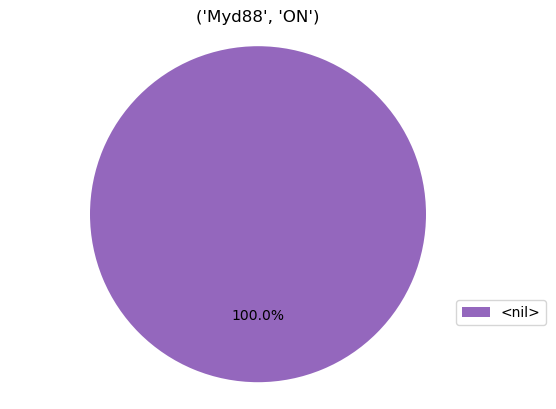

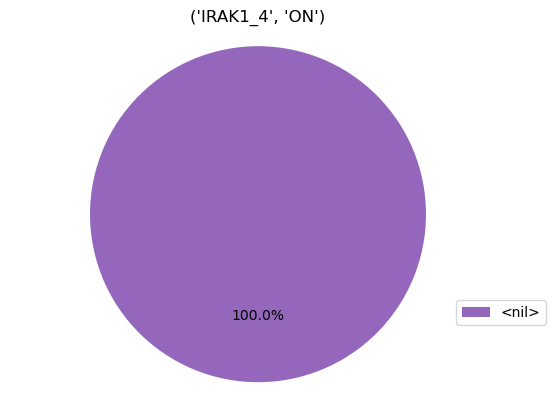

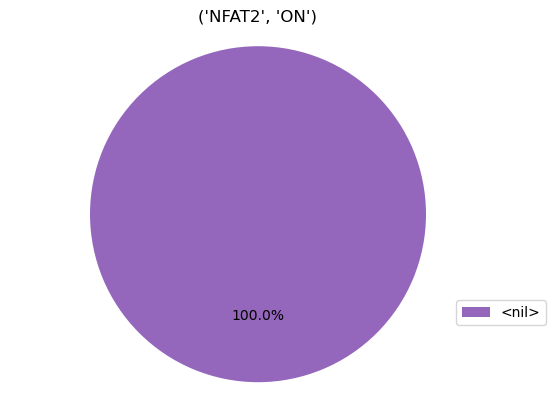

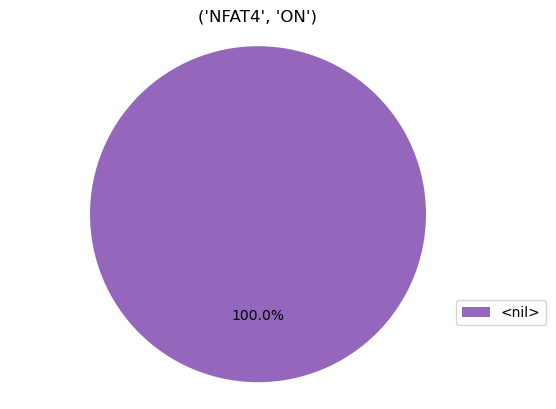

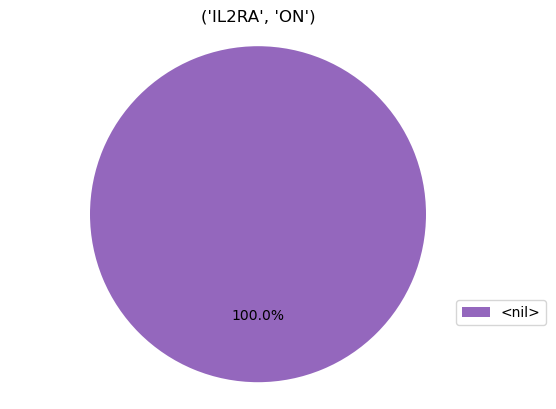

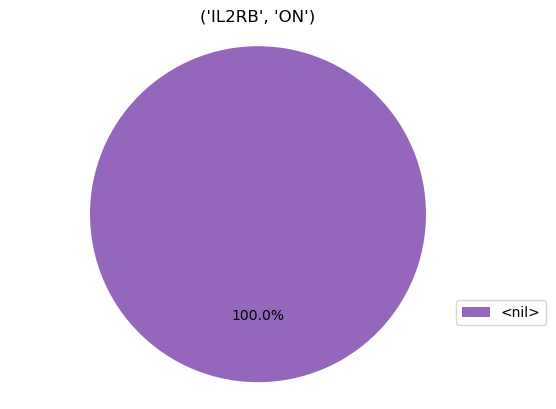

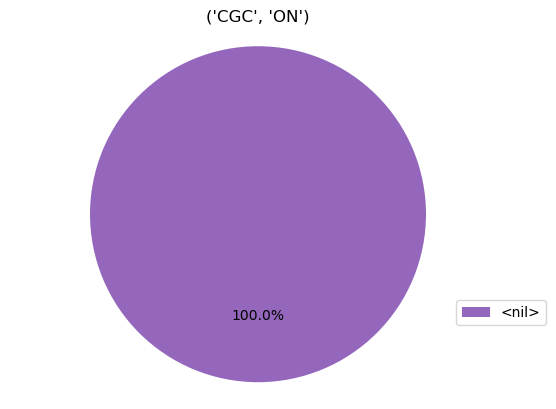

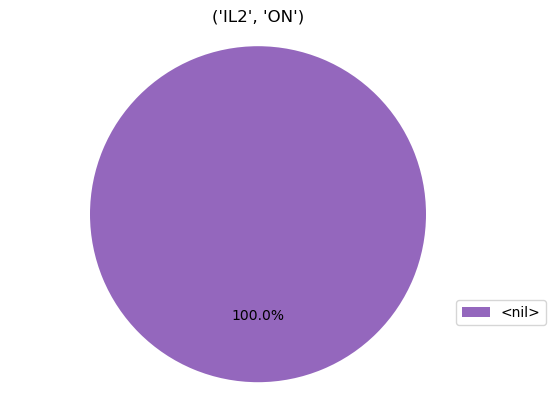

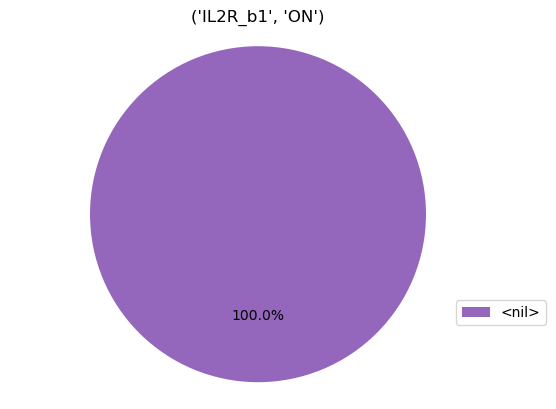

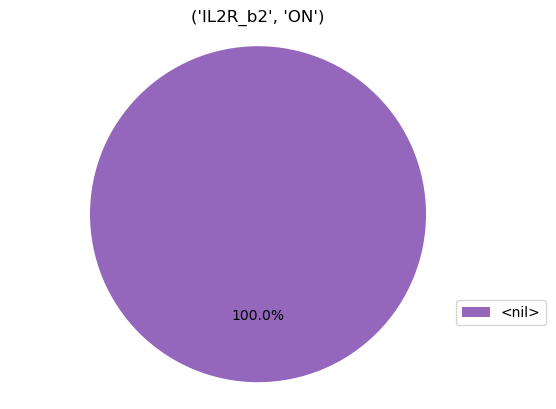

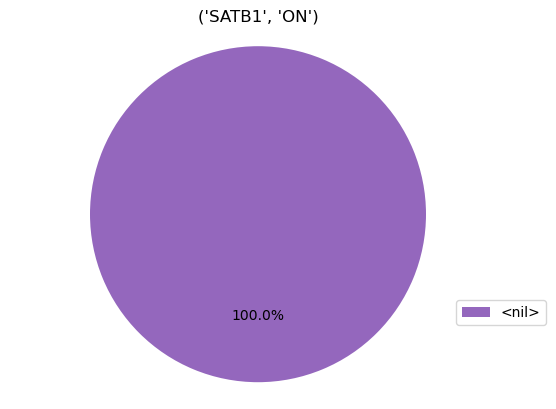

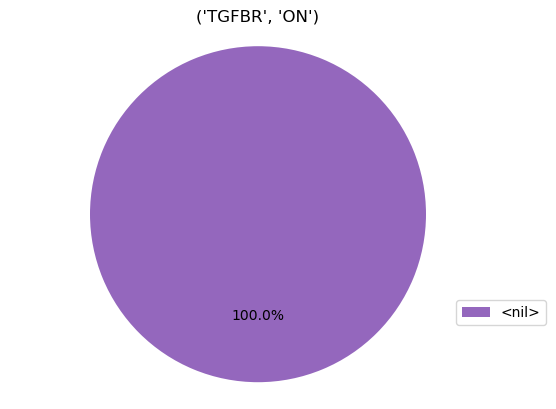

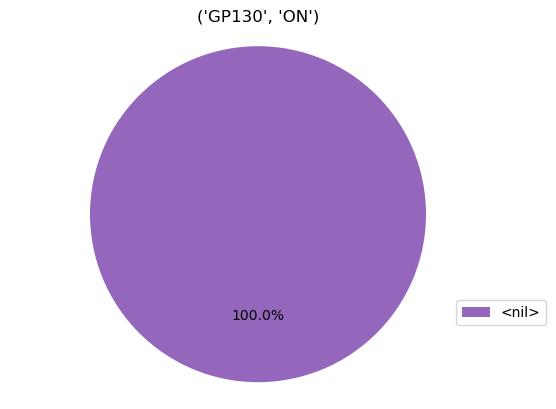

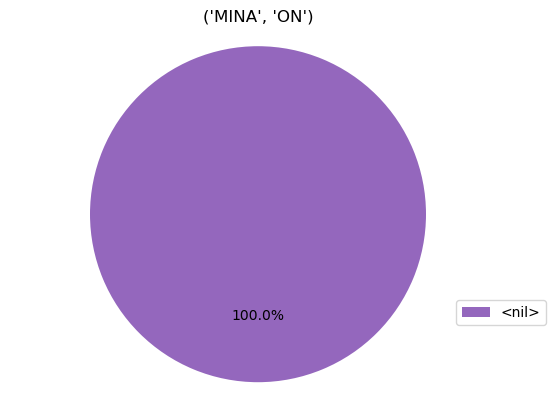

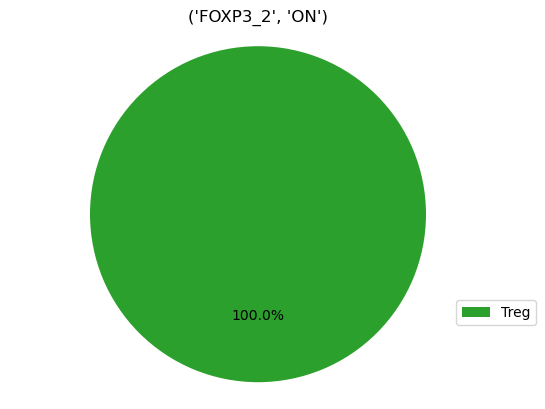

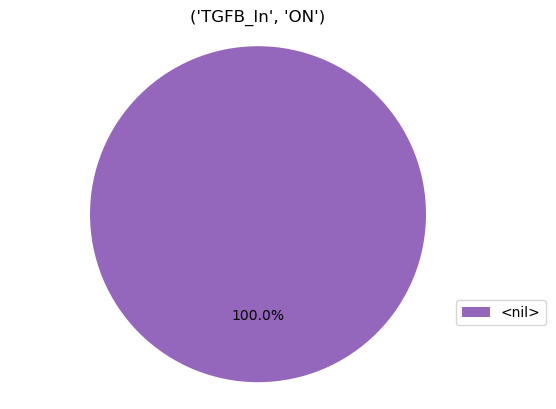

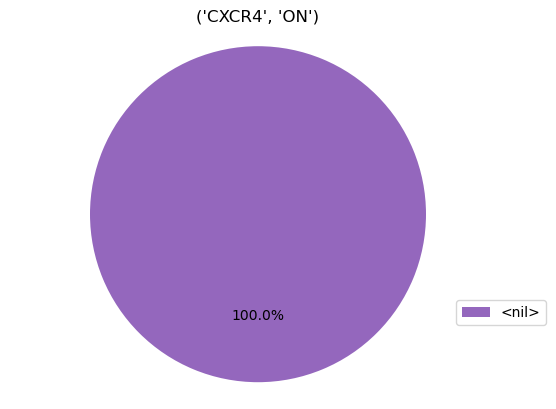

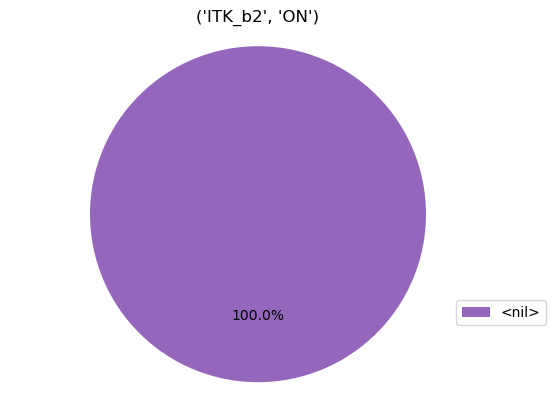

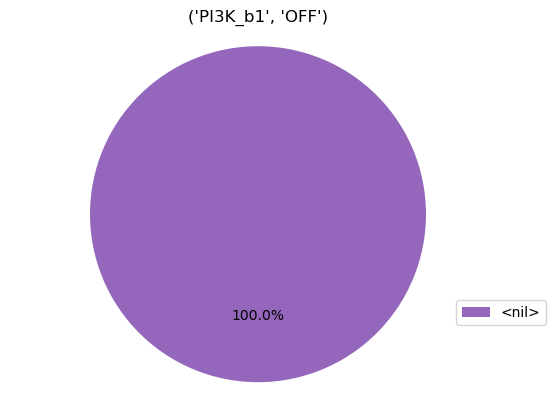

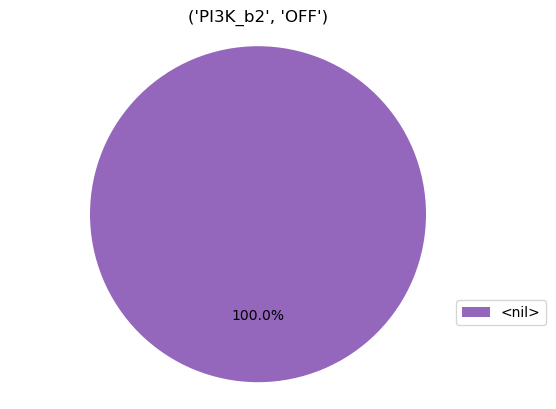

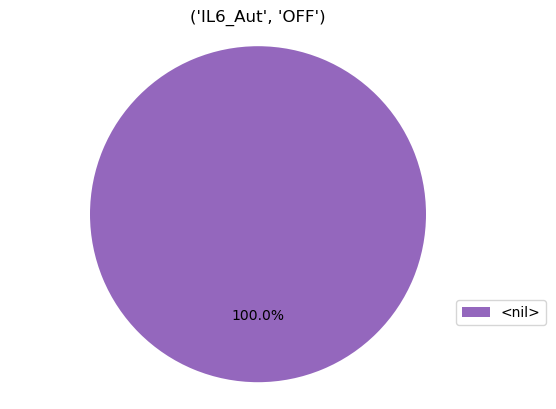

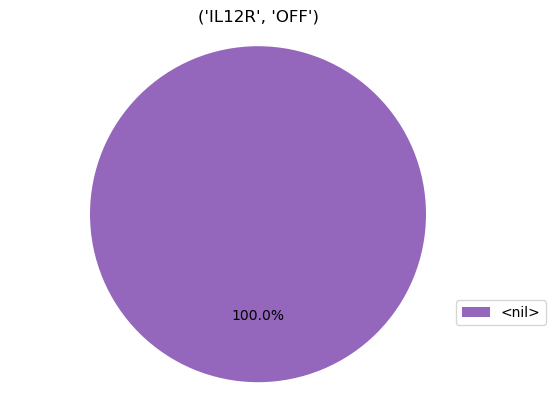

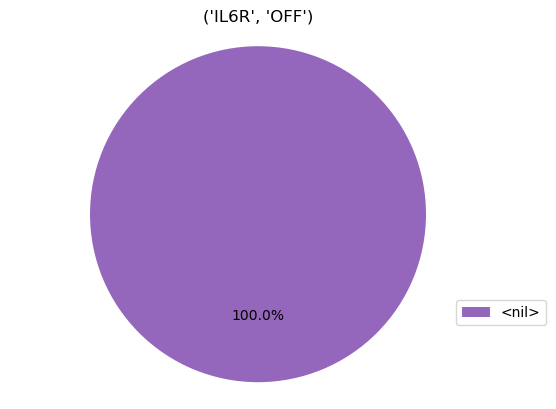

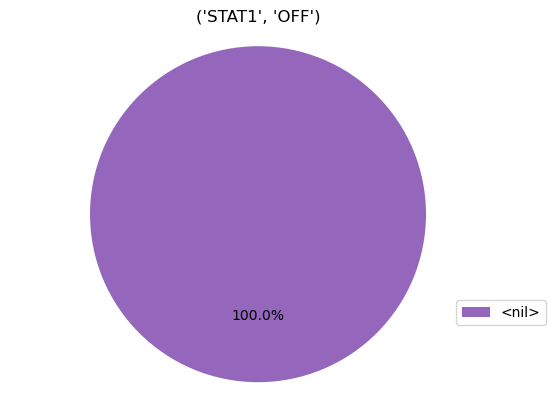

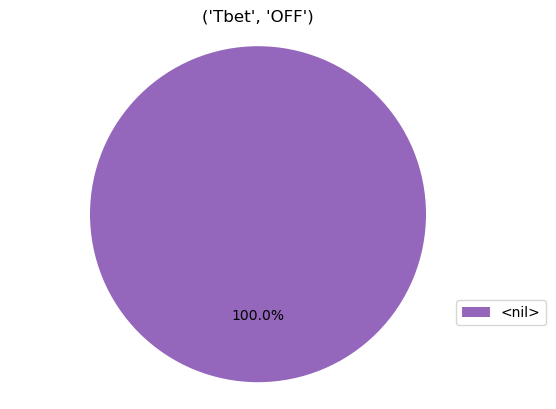

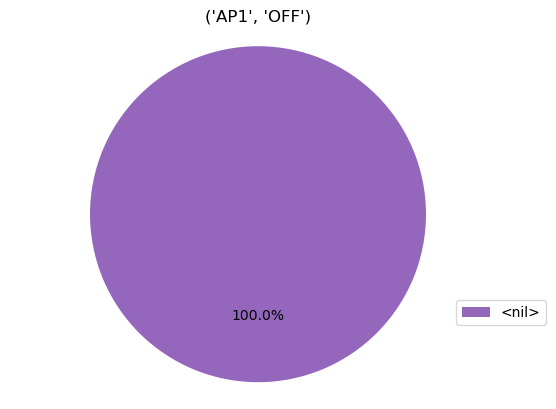

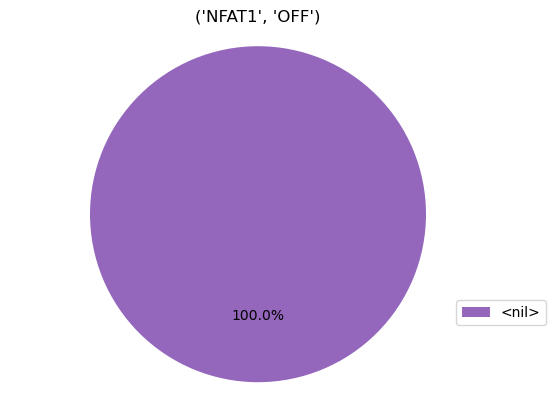

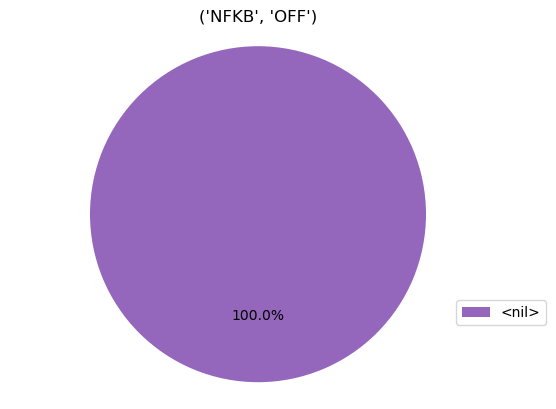

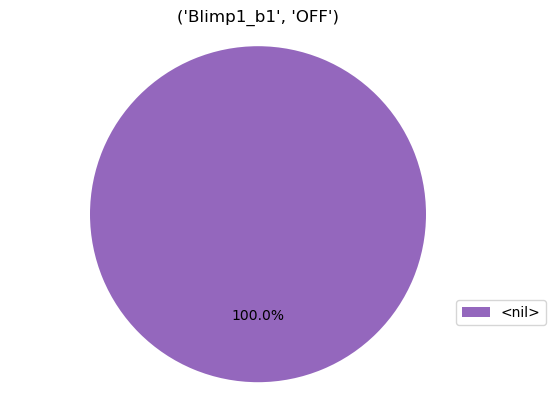

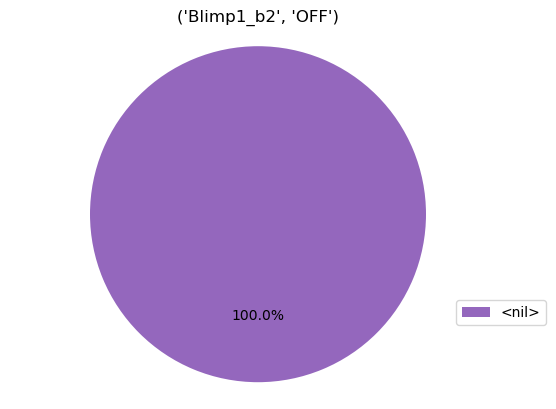

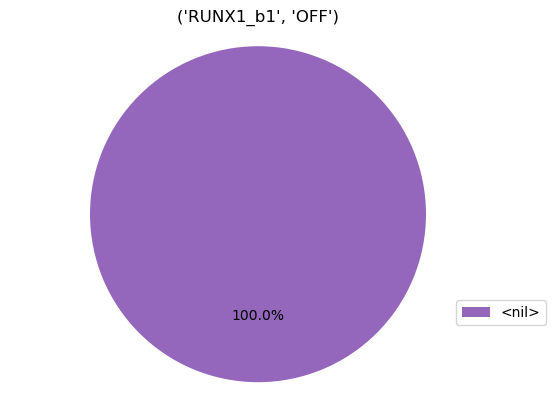

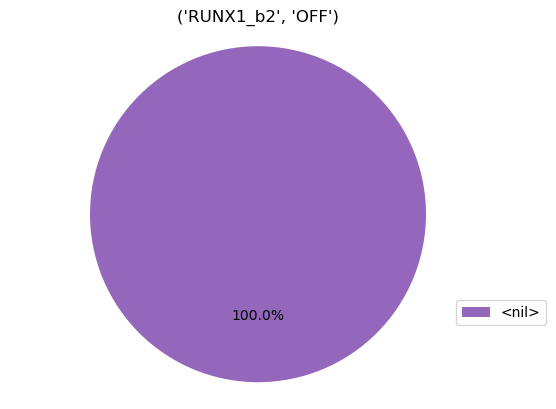

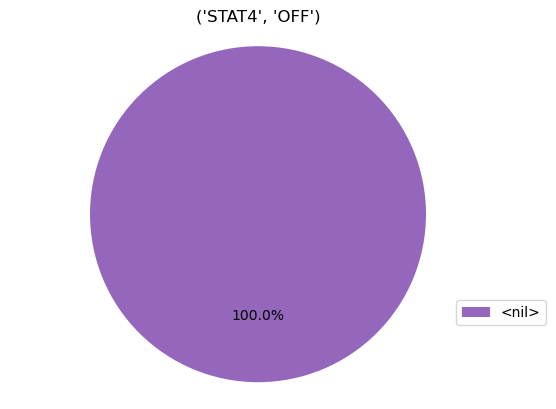

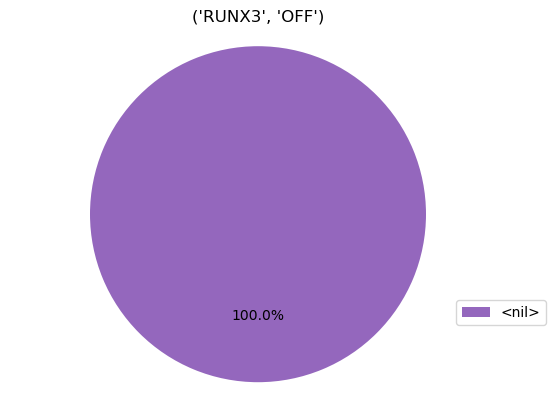

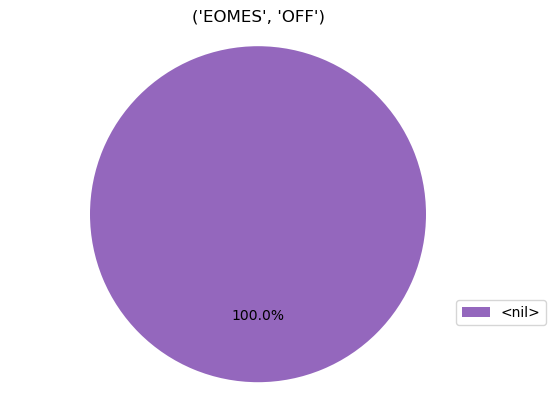

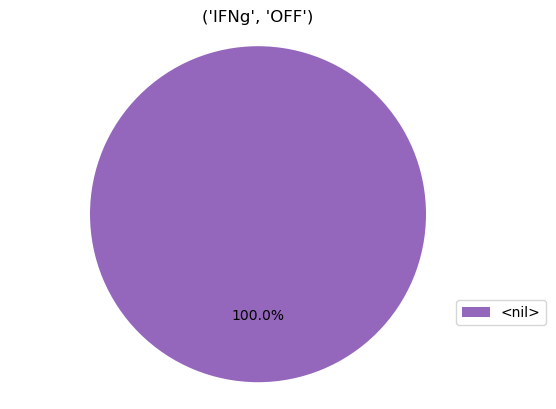

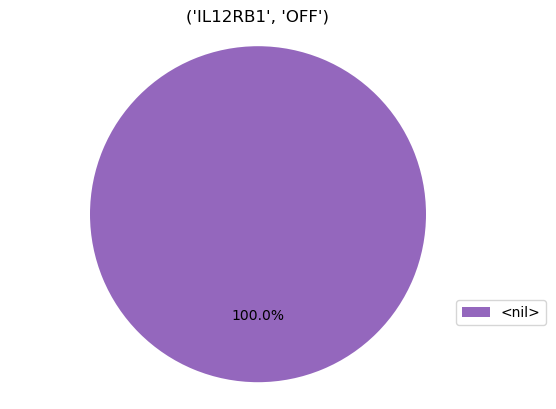

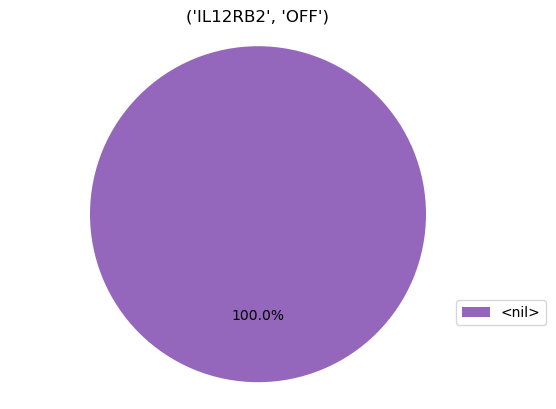

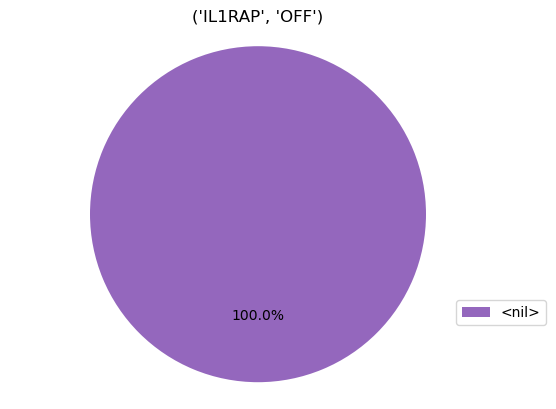

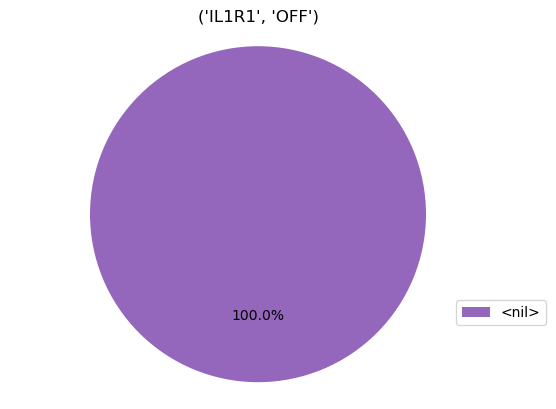

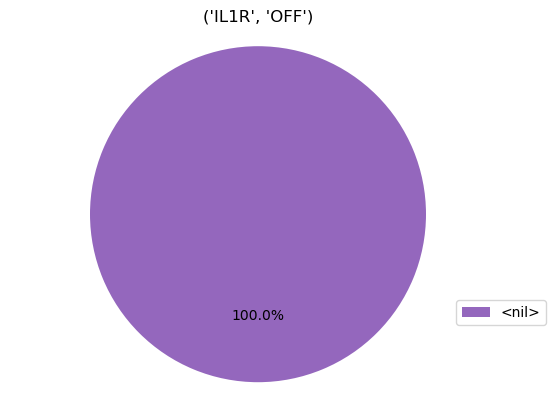

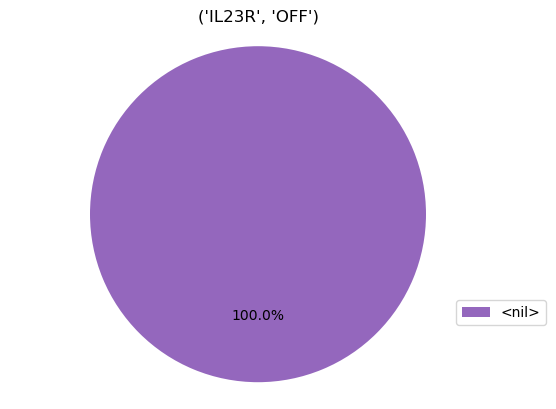

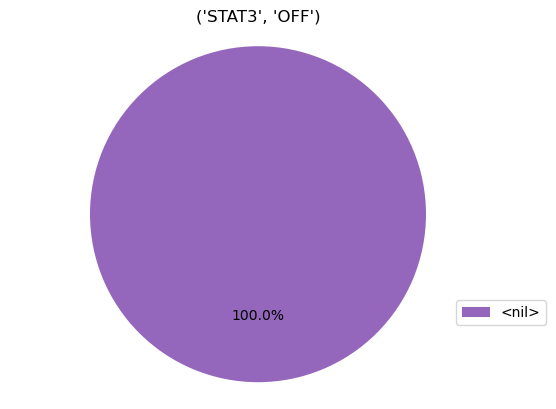

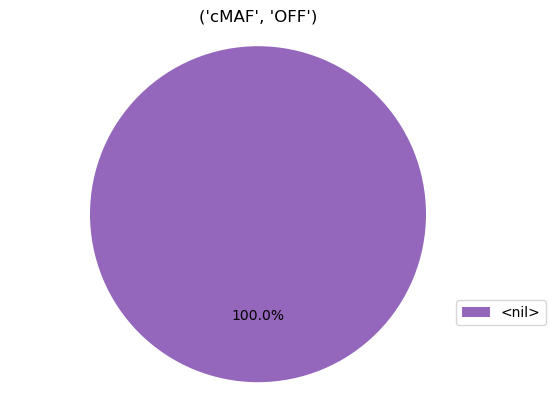

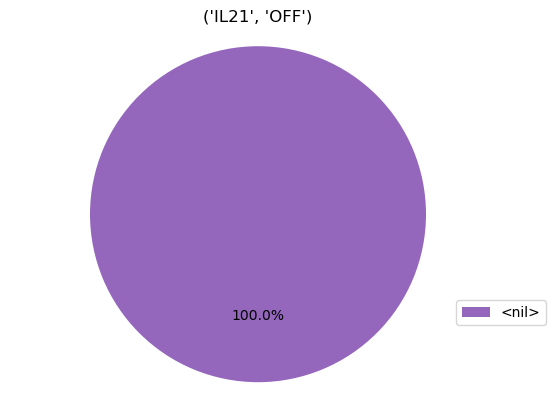

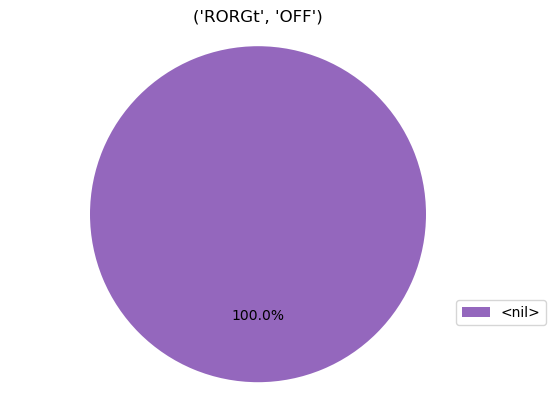

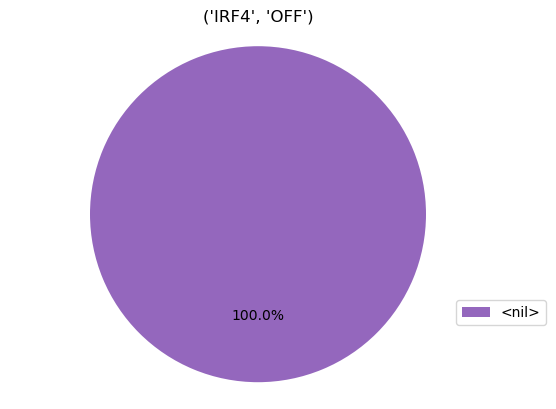

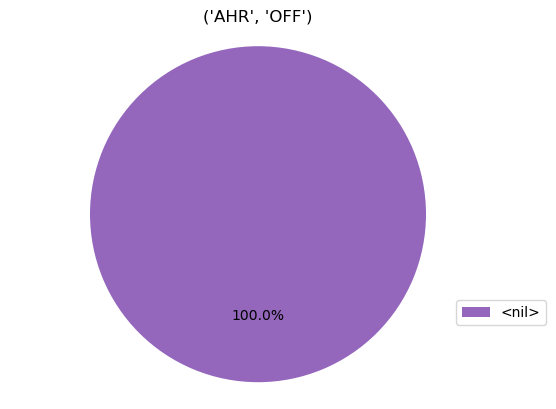

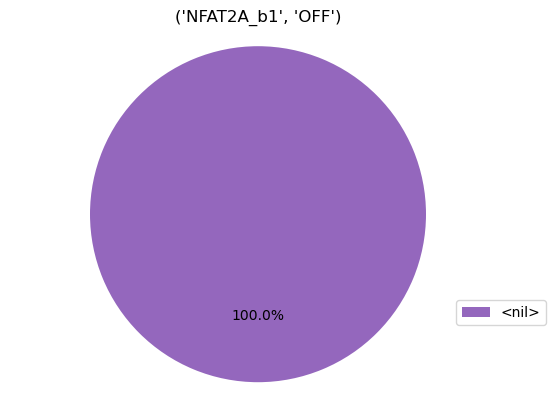

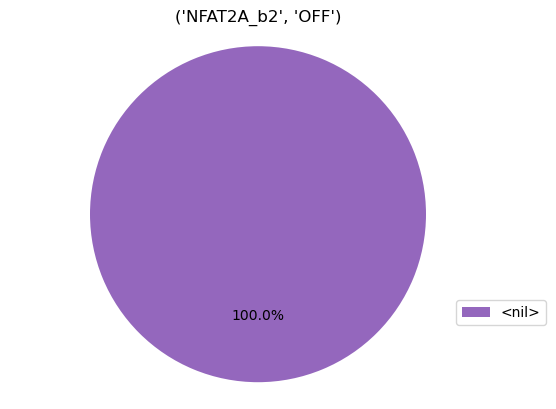

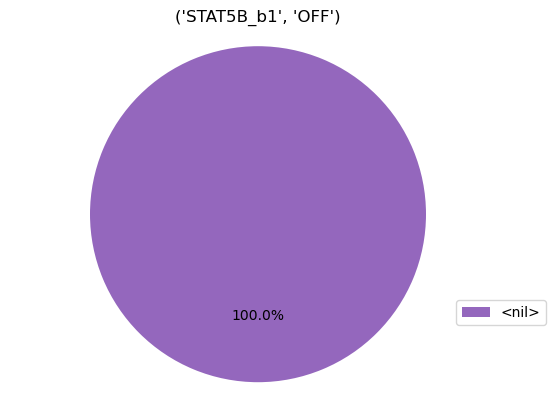

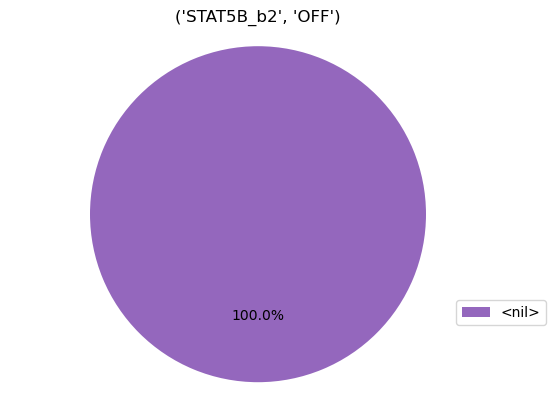

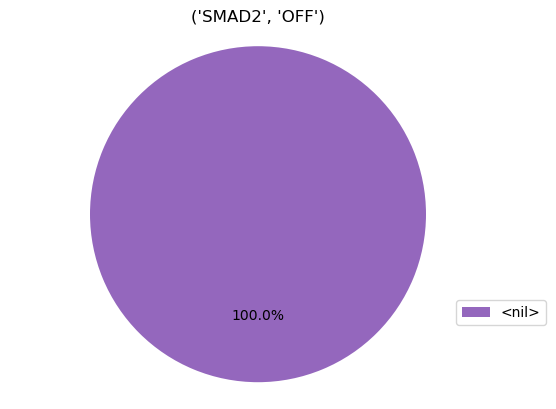

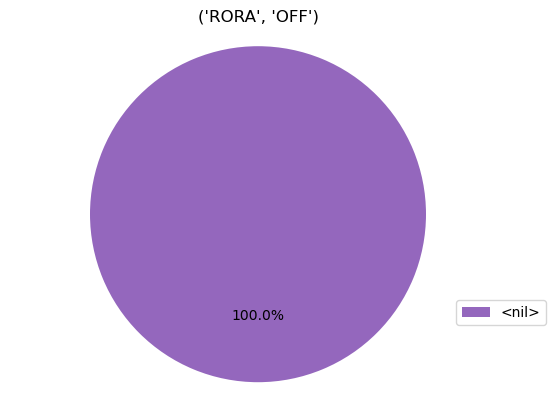

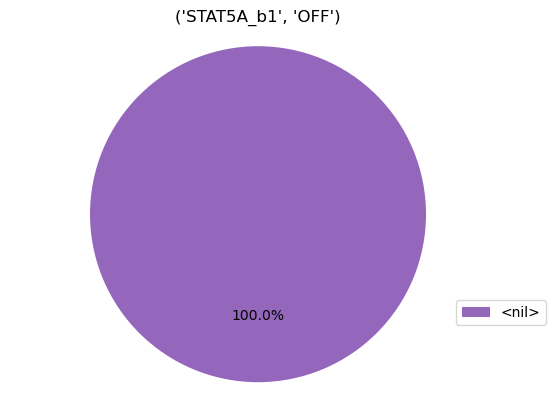

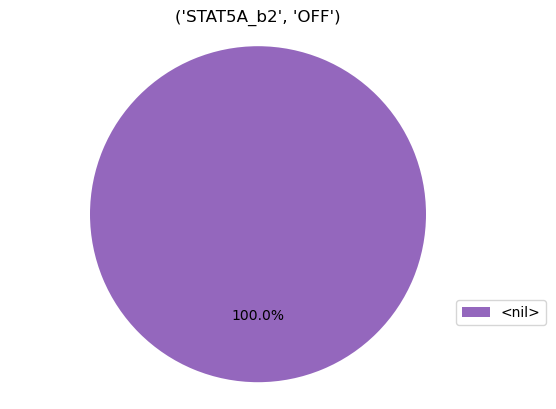

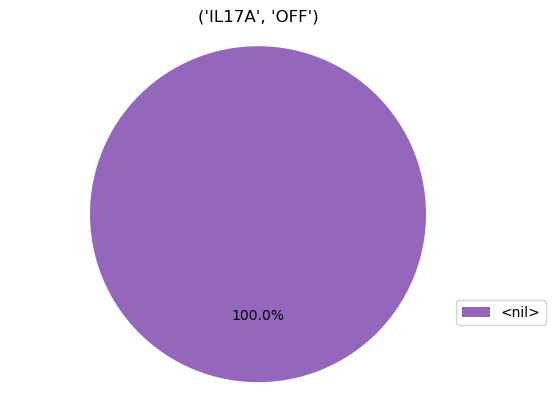

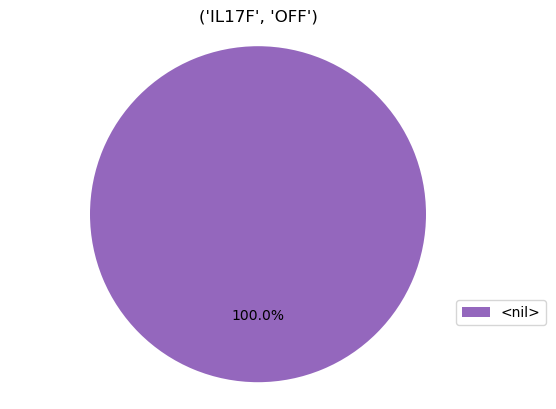

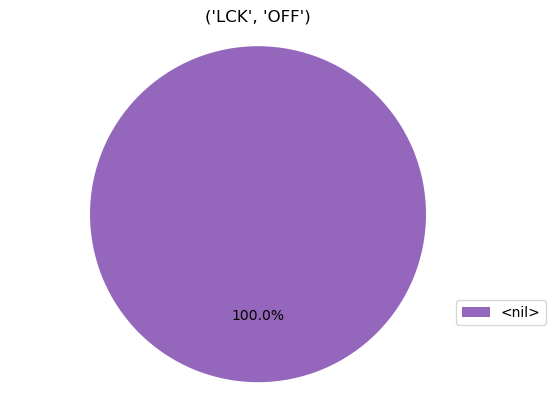

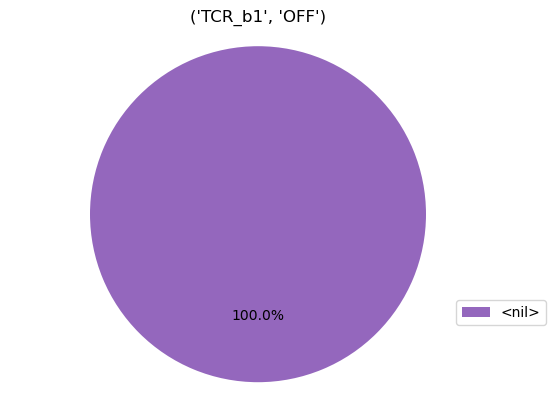

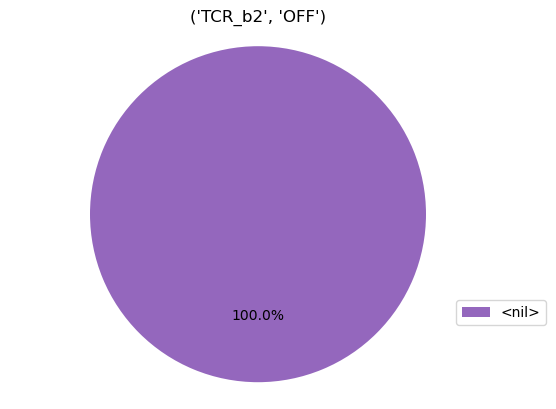

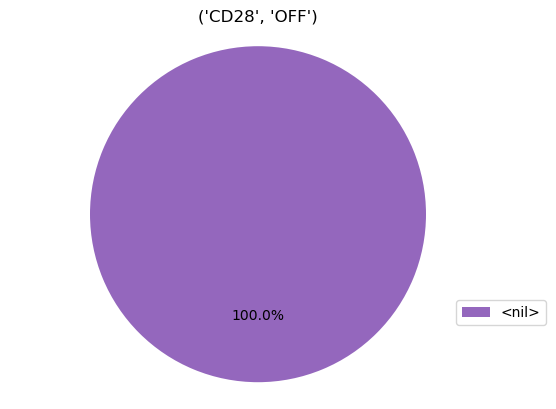

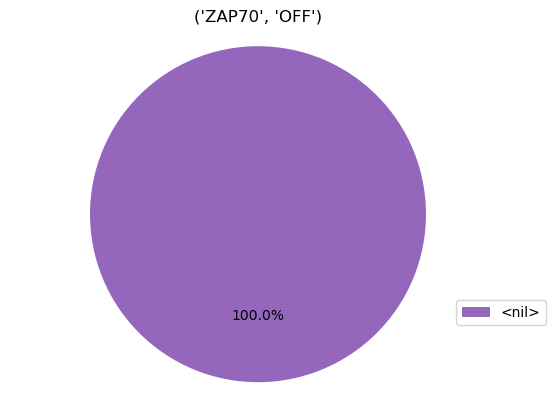

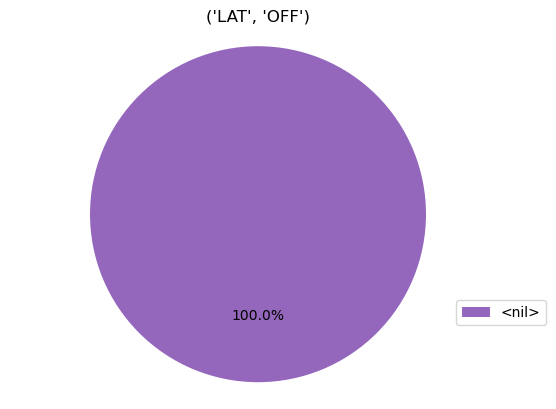

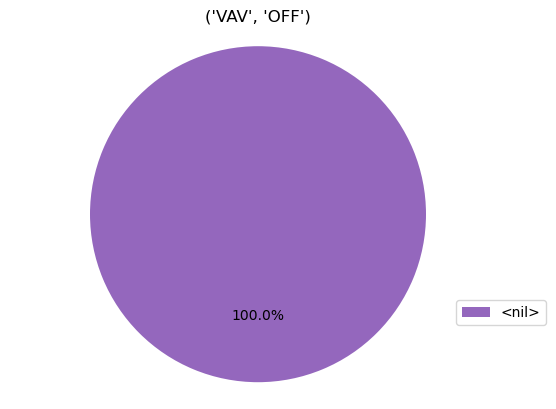

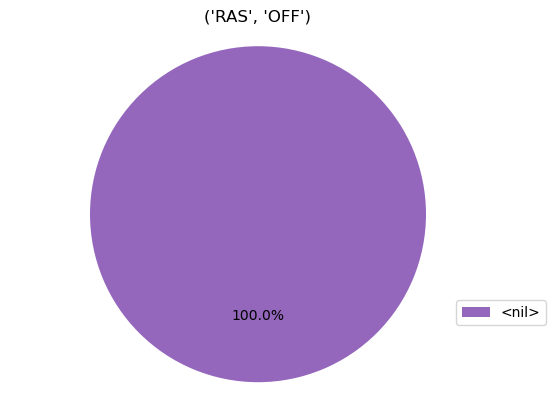

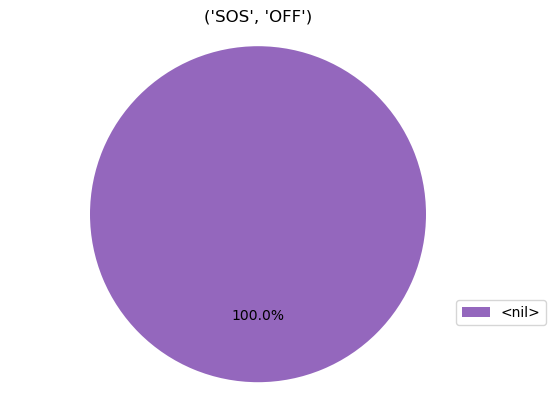

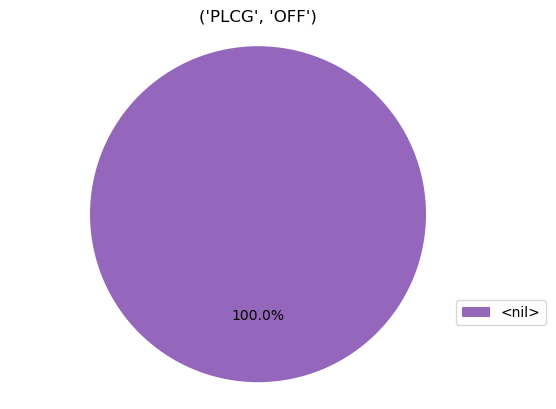

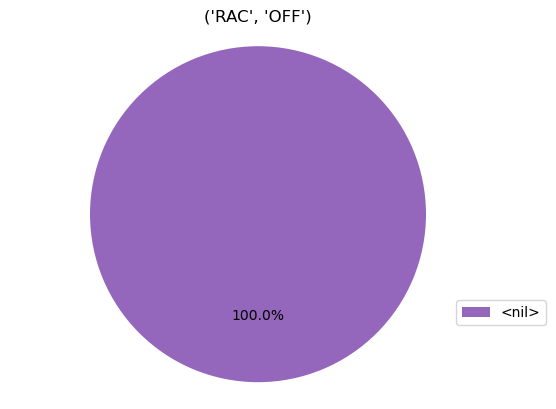

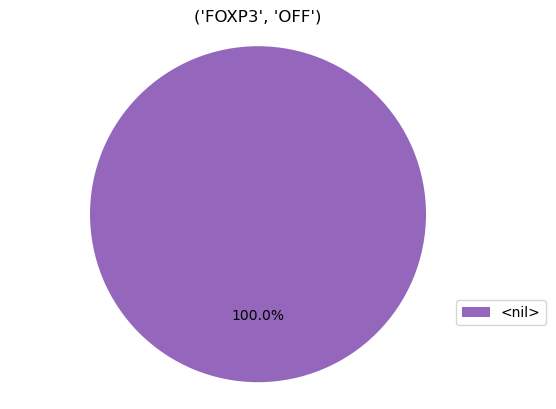

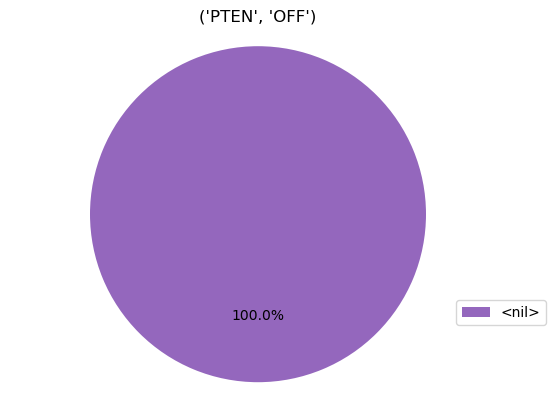

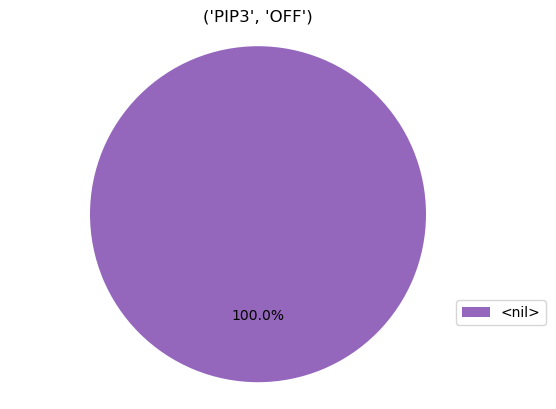

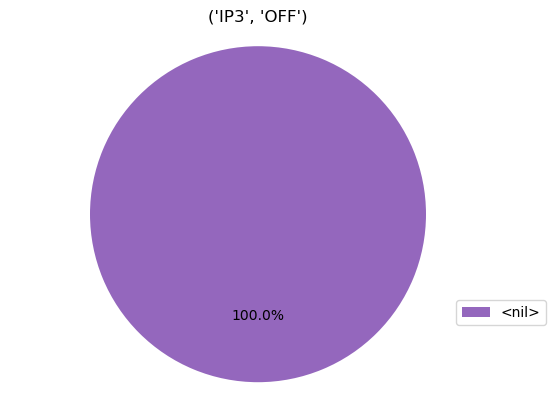

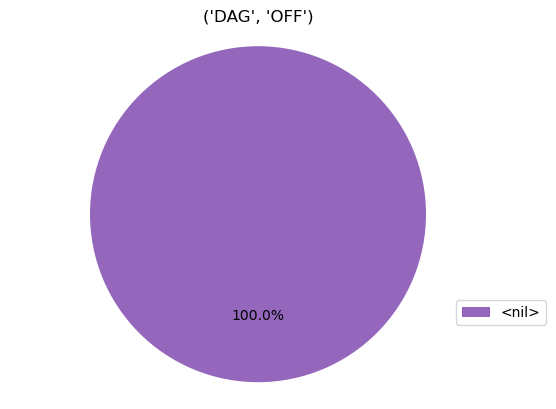

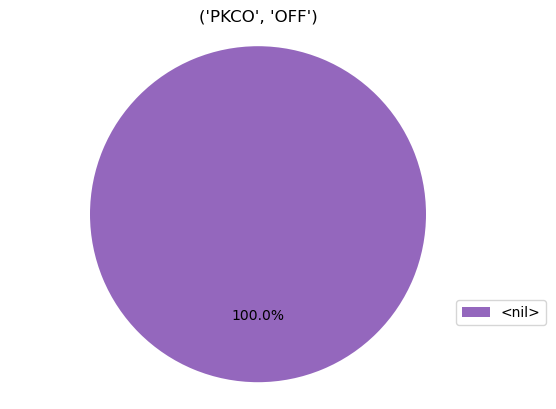

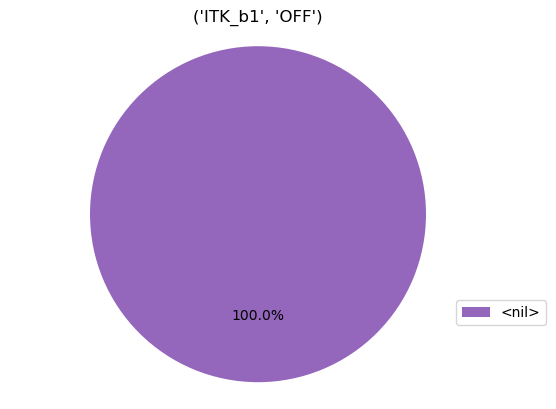

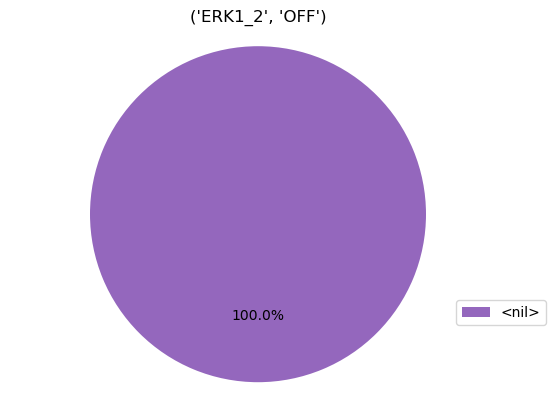

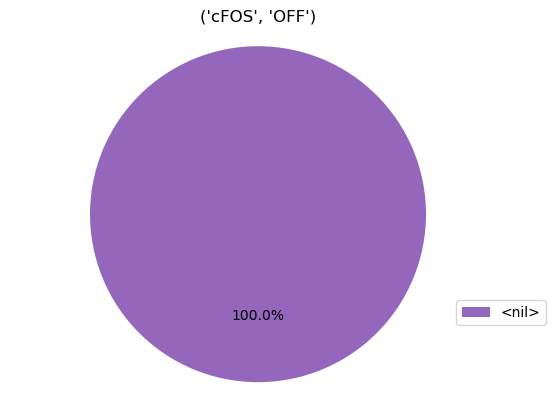

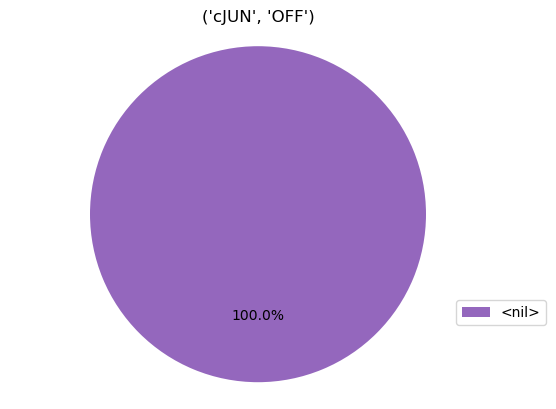

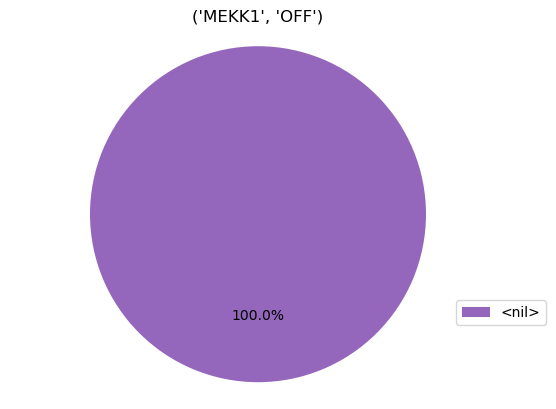

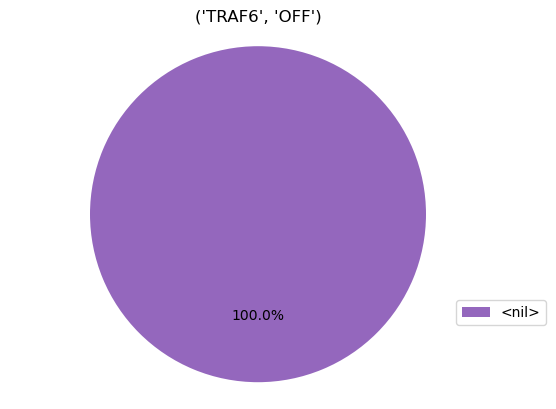

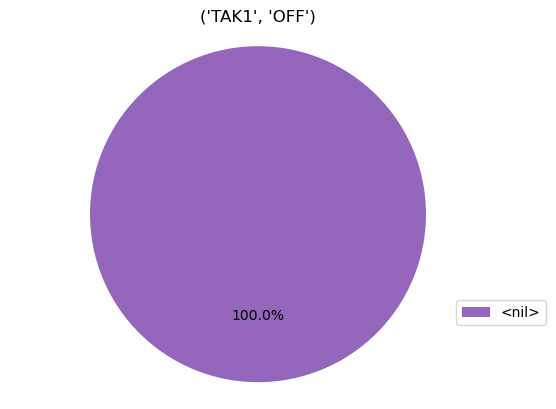

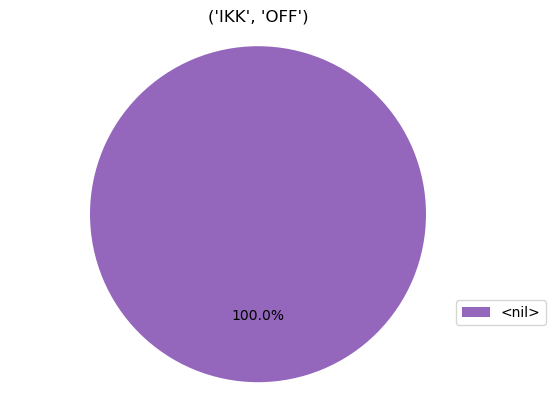

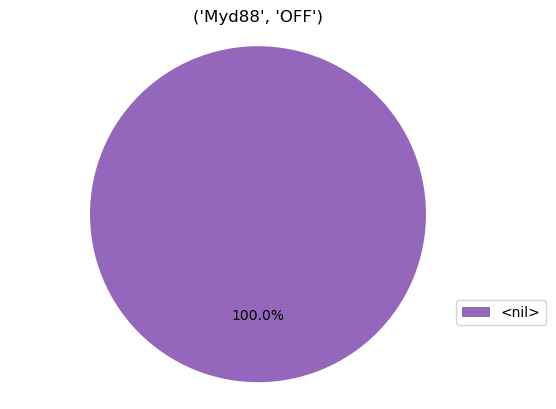

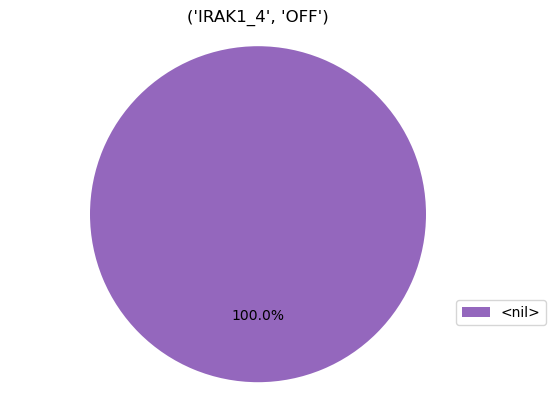

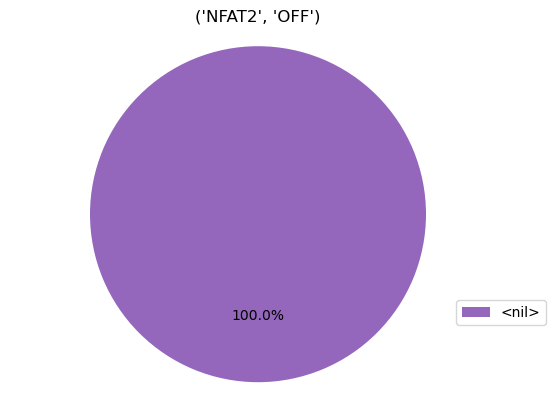

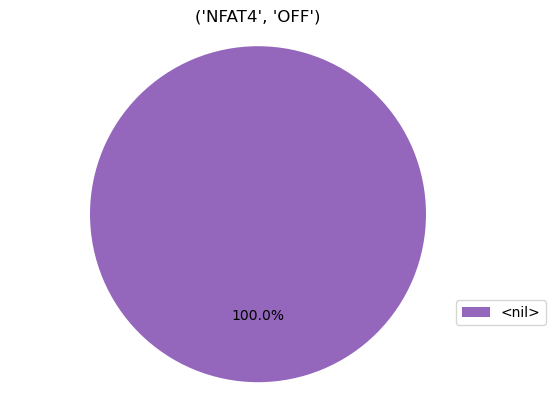

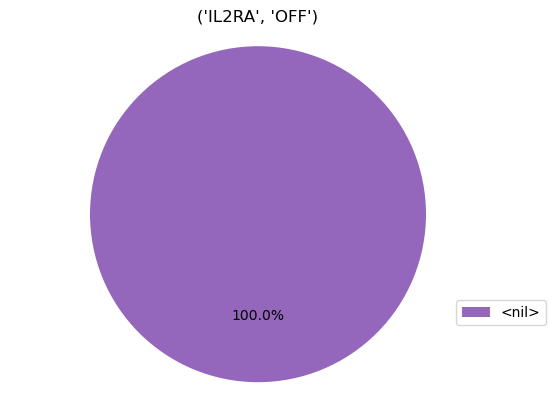

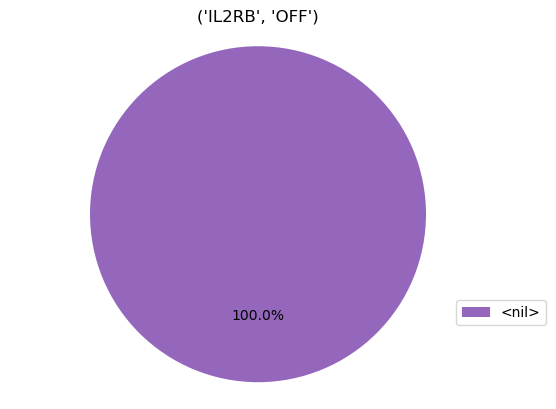

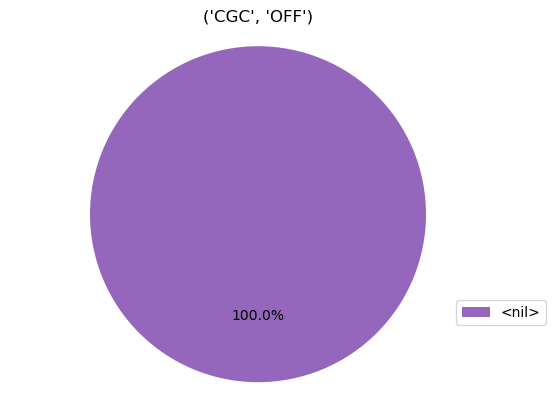

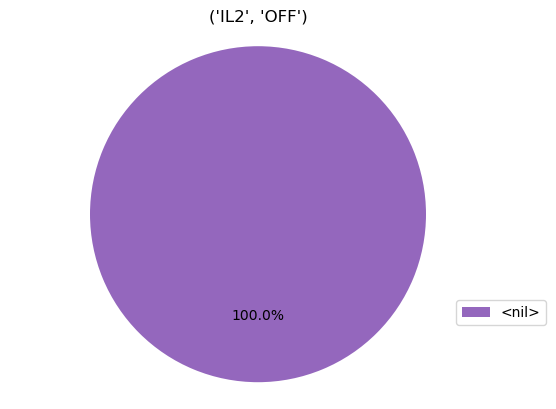

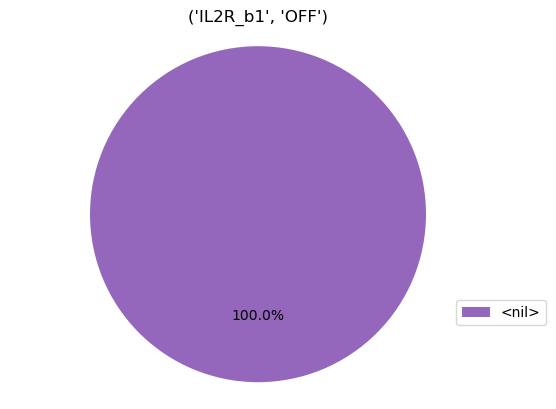

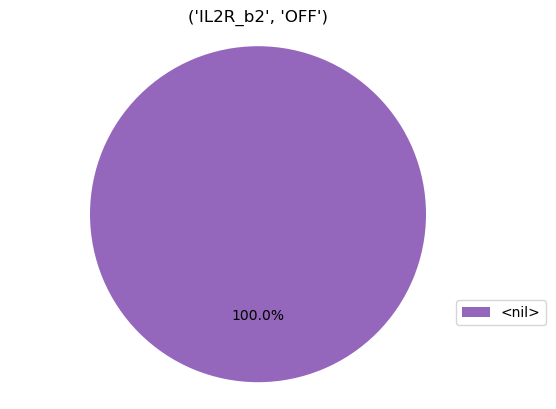

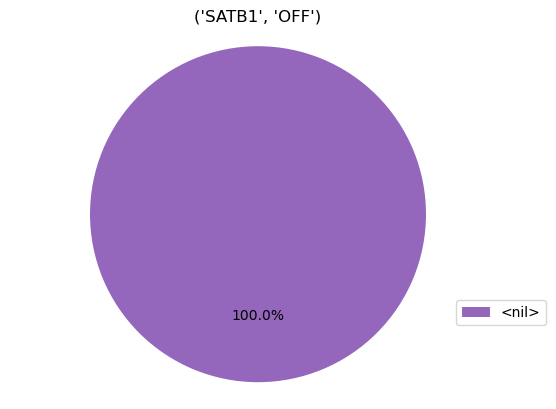

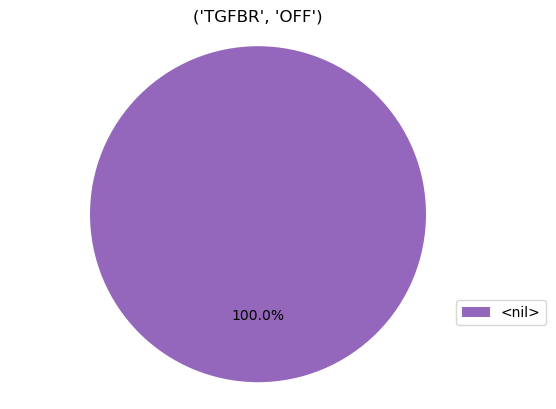

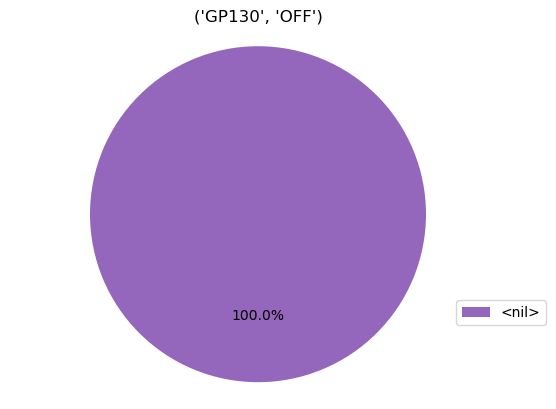

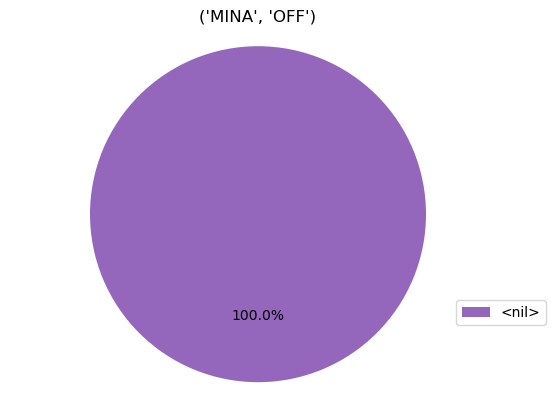

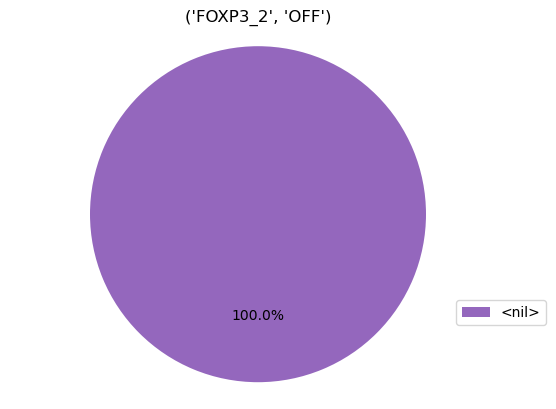

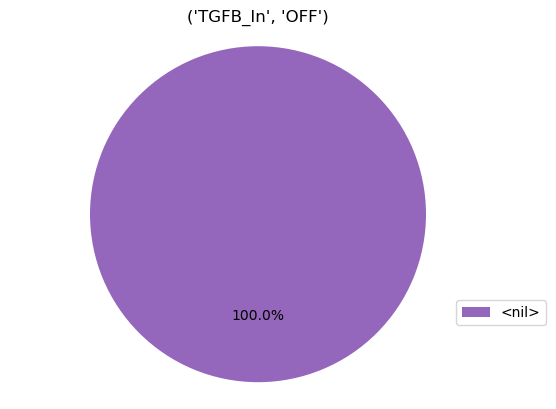

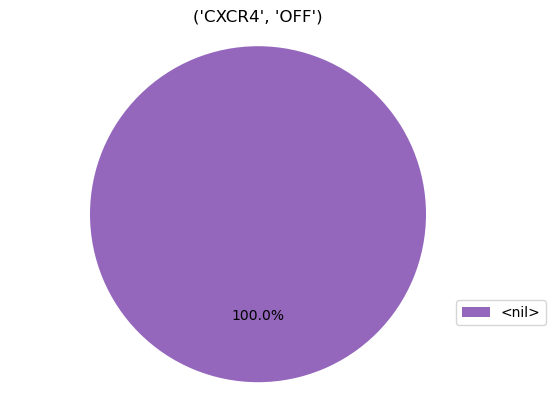

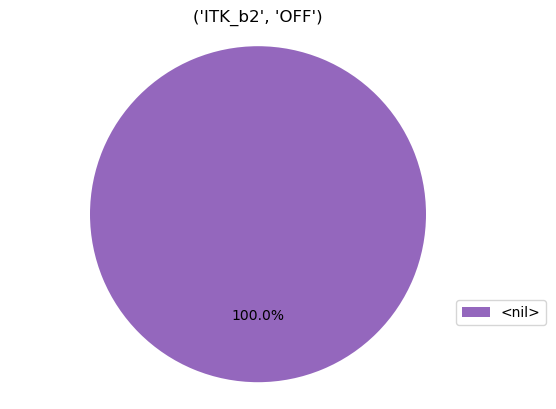

In [124]:
res_double = simulate_double_mutants(sim_test_double_mut, nodes_test)

In [125]:
filtered_res_double_mut = filter_sensititivy(res_double, node="Treg", maximum=0)
filtered_res_double_mut = filter_sensititivy(filtered_res_double_mut, node="Th1", maximum=0)
filtered_res_double_mut = filter_sensititivy(filtered_res_double_mut, node="Th17", maximum=0)
filtered_res_double_mut

{(('PI3K_b1', 'ON'),
  ('PI3K_b2', 'ON')): <maboss.result.Result at 0x7f914b633e20>,
 (('PI3K_b1', 'ON'),
  ('IL6_Aut', 'ON')): <maboss.result.Result at 0x7f914b7f69a0>,
 (('PI3K_b1', 'ON'),
  ('IL12R', 'ON')): <maboss.result.Result at 0x7f914b956af0>,
 (('PI3K_b1', 'ON'), ('IL6R', 'ON')): <maboss.result.Result at 0x7f914d01dd90>,
 (('PI3K_b1', 'ON'),
  ('STAT1', 'ON')): <maboss.result.Result at 0x7f914cfc4c40>,
 (('PI3K_b1', 'ON'), ('AP1', 'ON')): <maboss.result.Result at 0x7f914d07e5b0>,
 (('PI3K_b1', 'ON'),
  ('NFAT1', 'ON')): <maboss.result.Result at 0x7f914cfcf6a0>,
 (('PI3K_b1', 'ON'), ('NFKB', 'ON')): <maboss.result.Result at 0x7f914cec2130>,
 (('PI3K_b1', 'ON'),
  ('Blimp1_b1', 'ON')): <maboss.result.Result at 0x7f915549e880>,
 (('PI3K_b1', 'ON'),
  ('Blimp1_b2', 'ON')): <maboss.result.Result at 0x7f914b956640>,
 (('PI3K_b1', 'ON'),
  ('RUNX1_b1', 'ON')): <maboss.result.Result at 0x7f914d01d5b0>,
 (('PI3K_b1', 'ON'),
  ('RUNX1_b2', 'ON')): <maboss.result.Result at 0x7f914cec22b

In [126]:
stable_state = sim.copy()
nodes = list(stable_state.network.keys())
inputs = input_tcell_dict = {element: 1 for element in input_tcell}
stable_state.network.set_output(output_maboss)

In [130]:
updated_double_mutations = compute_input_on_mutations(stable_state, filtered_res_double_mut, nodes, inputs)

In [164]:
filtered_res_double_mut_threg = filter_sensititivy(updated_double_mutations, node="Treg", maximum=0.441)
filtered_res_double_mut_threg

{(('STAT4', 'ON'),
  ('STAT5A_b2', 'OFF')): <maboss.result.Result at 0x7f90b68b4910>}

(('STAT4', 'ON'), ('STAT5A_b2', 'OFF'))


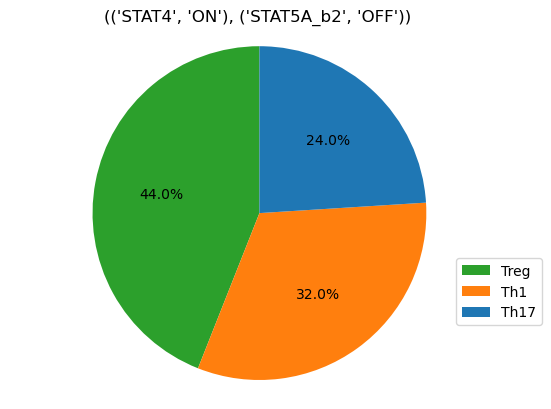

In [165]:
for mutant, res in filtered_res_double_mut_threg.items():
    print(mutant)
    res.plot_piechart()
    plt.title(mutant)

In [167]:
filtered_res_double_mut_Th1 = filter_sensititivy(updated_double_mutations, node="Th1", maximum=0.224)
filtered_res_double_mut_Th1

{(('Blimp1_b1', 'ON'),
  ('IL6R', 'OFF')): <maboss.result.Result at 0x7f90a25bf940>,
 (('IFNg', 'ON'),
  ('STAT5B_b2', 'OFF')): <maboss.result.Result at 0x7f90c5919280>}

(('Blimp1_b1', 'ON'), ('IL6R', 'OFF'))
(('IFNg', 'ON'), ('STAT5B_b2', 'OFF'))


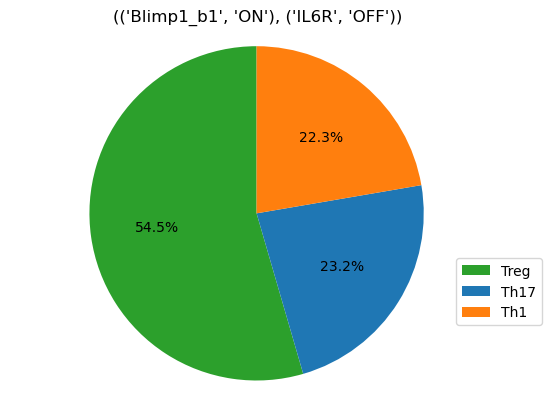

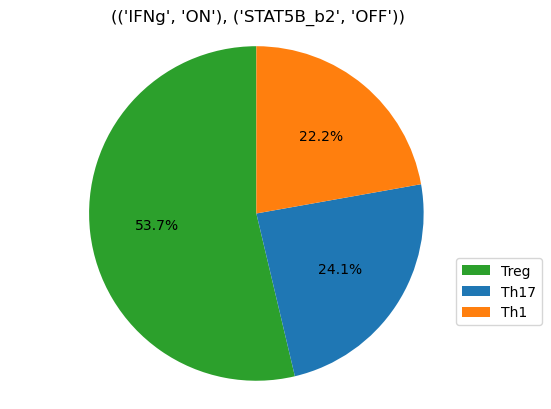

In [168]:
for mutant, res in filtered_res_double_mut_Th1.items():
    print(mutant)
    res.plot_piechart()
    plt.title(mutant)

In [159]:
filtered_res_double_mut_th17 = filter_sensititivy(updated_double_mutations, node="Th17", maximum=0.18)
filtered_res_double_mut_th17

{(('STAT5B_b2', 'ON'),
  ('GP130', 'OFF')): <maboss.result.Result at 0x7f9104f2cca0>,
 (('ITK_b2', 'ON'), ('MINA', 'OFF')): <maboss.result.Result at 0x7f8ffe200940>}

(('STAT5B_b2', 'ON'), ('GP130', 'OFF'))
(('ITK_b2', 'ON'), ('MINA', 'OFF'))


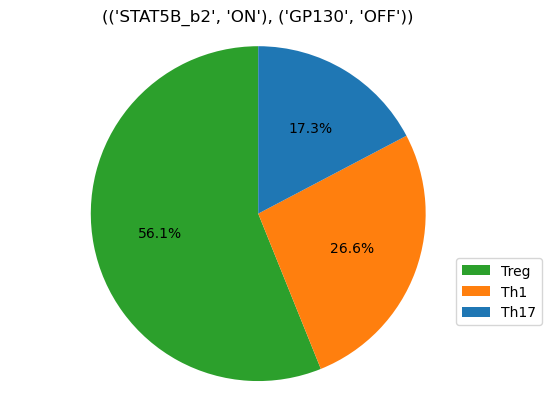

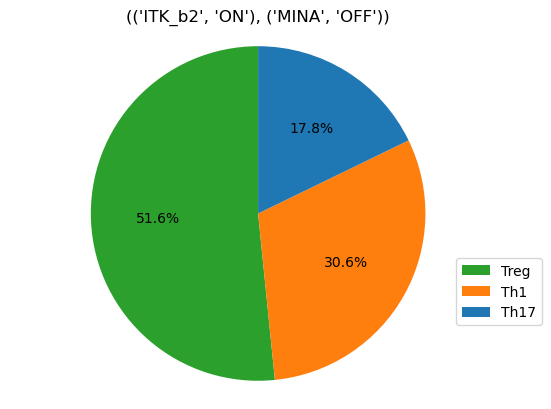

In [160]:
for mutant, res in filtered_res_double_mut_th17.items():
    print(mutant)
    res.plot_piechart()
    plt.title(mutant)

## The effect of the double mutations founded above is slightly better than the effect of the single mutations. Once again, at low number of cell population, this may not have visible effect, but it could have for a large number of cells.